## Install and import libraries

In [1]:
# pip install pip==21.3.1

In [2]:
pip install scipy dtaidistance fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512616 sha256=908996407b9e639415a09f3de214158daf47185a34e79f4c06326d1f9e7102cf
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install h5py typing-extensions wheel

In [5]:
pip install diffrax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 371.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.5 MB/s eta 0:00:00


In [6]:
pip install celluloid

In [7]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
import numpy as np
import cvxpy as cp

## Read and plot the demo

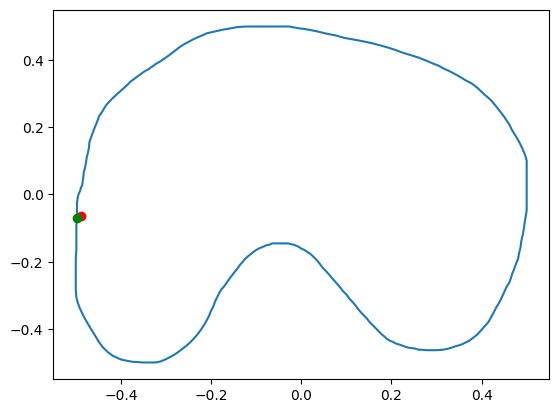

In [8]:
# Reading data from text file

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

flag = None
traj_all = []
traj_c = 0

# file_name = '/content/drive/MyDrive/Colab Notebooks/trajs_loop_1.txt'

file_name = '/content/drive/MyDrive/Colab Notebooks/trajs_loop_4.txt'

# file_name = '/content/drive/MyDrive/Colab Notebooks/trajs_TB.txt'

f = open(file_name, 'r')
data_text = f.readlines()
for i in data_text:
    if i == 'New trajectory\n':
        flag = 'new'
        if traj_c > 0:
            traj_all.append(traj)
        traj_c += 1
        continue
    if flag == 'new':
        traj = np.fromstring(i, dtype=float, sep=' ').reshape((1, 2))
        flag = 'old'
        continue
    if flag == 'old':
        traj = np.concatenate((traj, np.fromstring(i, dtype=float, sep=' ').reshape((1, 2))))
traj_all.append(traj)

traj_all_norm = []
ts_norm = []
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
scaler_all = []
for i in range(len(traj_all)):
    scaler.fit(traj_all[i])
    scaler_all.append(scaler)
    ysti = scaler.transform(traj_all[i])
    traj_all_norm.append(ysti)
    ts_norm.append(jnp.linspace(0,1,num=ysti.shape[0]))
    # scaler.fit(ts.reshape(-1, 1))
    # tst = scaler.transform(ts.reshape(-1, 1))
    # tst = tst.reshape(-1, )

dim = traj.shape[1]

nsamples = 300

data_aug = 0

traj_all_process = jnp.zeros((traj_c + data_aug, nsamples, dim))

seed = 1385

key = jax.random.PRNGKey(seed)

key_trajs = jax.random.split(key, num=traj_c + data_aug)

for i in range(traj_c + data_aug):
  key_dim = jax.random.split(key_trajs[i], num=dim)
  for j in range(dim):
    f = interpolate.interp1d(ts_norm[i], traj_all_norm[i][:, j])
    ts_new = np.linspace(0, 1, nsamples)
    range_traj = max(traj_all_norm[i][:, j]) - min(traj_all_norm[i][:, j])
    scale = 0
    traj_new = f(ts_new) + jax.random.uniform(key_dim[j], shape=ts_new.shape, minval=-scale*range_traj, maxval=scale*range_traj)
    traj_all_process = traj_all_process.at[i, :, j].set(traj_new)

traj_d = jnp.diff(traj_all_process, axis=1)
traj_d = jnp.concatenate((traj_d, jnp.zeros((traj_c + data_aug, 1, dim))), axis=1)
traj_d_all = jnp.concatenate((traj_all_process, traj_d), axis=2)

for i in range(traj_c + data_aug):
    plt.plot(traj_all_process[i][0, 0], traj_all_process[i][0, 1], 'ro')
    plt.plot(traj_all_process[i][:, 0], traj_all_process[i][:, 1])
    plt.plot(traj_all_process[i][-1, 0], traj_all_process[i][-1, 1], 'go')

## Define models

In [9]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    @eqx.filter_jit
    def __call__(self, t, y, args):

        return self.mlp(y)

In [10]:
class Funcd(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=2*data_size,
            out_size=2*data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    @eqx.filter_jit
    def __call__(self, t, yd, args):

        return self.mlp(yd)

In [11]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [12]:
class NeuralODEd(eqx.Module):
    func: Funcd

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Funcd(data_size, width_size, depth, key=key)

    @eqx.filter_jit
    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

## Dataloader

In [ ]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

## Training

In [ ]:
# @title
def main(
    dataset_size=int(1),
    batch_size=int(1),
    lr_strategy=(3e-3,9e-4,9e-4,),
    steps_strategy=(3000,4000,4000,),
    length_strategy=(0.5,0.7,1,),
    width_size=128,
    depth=3,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    # ts, ys, ys_dot = get_data(dataset_size, key=data_key)

    # training data

    # traj_all_process = traj_TB_all_process
    # # traj_d_all = traj_TB_d_all
    # ts_new = ts_TB_new

    ys = traj_all_process[:dataset_size]
    ys_all = traj_d_all[:dataset_size]
    ts = ts_new

    _, length_size, data_size = ys.shape

    # model = NeuralODE(data_size, width_size, depth, key=model_key)
    model = NeuralODE(data_size, width_size, depth, key=model_key)
    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_d_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        # f = lambda z: model.func(_, z, _)
        # y_dot_pred = jax.vmap(jax.vmap(f, in_axes = (0, 0)), in_axes=(None, 0))(ti, yi)
        loss = jnp.mean((yi - y_d_pred) ** 2)
        # loss = jnp.mean((y_dot_pred - yi_dot)**2)
        return loss

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        decay_scheduler = optax.cosine_decay_schedule(lr, decay_steps=steps, alpha=0.95)
        # decay_scheduler = optax.piecewise_constant_schedule(init_value=lr, boundaries_and_scales={int(steps*0.25):0.5, int(steps*0.5):0.5, int(steps*0.75):0.5})
        # decay_scheduler = optax.exponential_decay(init_value=lr, transition_steps=steps, decay_rate=0.98, transition_begin=int(steps*0.25), staircase=False)
        # decay_scheduler = optax.linear_schedule(init_value=lr, end_value=0.001*lr, transition_steps=steps, transition_begin=int(steps*0.25))
        optim = optax.adabelief(learning_rate=decay_scheduler)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        # _ys_all = ys_all[:, :int(length_size * length)]
        # _ys_dot = []
        for step in range(steps):
          start = time.time()
          loss, model, opt_state = make_step(_ts, _ys, model, opt_state)
          end = time.time()
          if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
        ## Batches
        # for step, (yi,) in zip(
        #     range(steps), dataloader((_ys,), batch_size, key=loader_key)
        # ):
        #     start = time.time()
        #     loss, model, opt_state = make_step(_ts, yi, model, opt_state)
        #     end = time.time()
        #     if (step % print_every) == 0 or step == steps - 1:
        #         print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    # if plot:
    #     plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
    #     plt.plot(ts, ys[0, :, 1], c="dodgerblue")
    #     model_y = model(ts, ys[0, 0])
    #     plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
    #     plt.plot(ts, model_y[:, 1], c="crimson")
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig("neural_ode.png")
    #     plt.show()

    return ts, ys, model

In [ ]:
ts, ys, model = main()

## Plot the prediction

In [ ]:
indx = 0
# traj_d_all = traj_spirals_d_all
model_y = model(2*ts, traj_all_process[indx, 0, :])
plt.plot(model_y[:,0], model_y[:,1], label="Model")
# indx = 6
# model_y = model(ts, traj_all_process[indx, 0, :])
# plt.plot(model_y[:,0], model_y[:,1], label="Model")
plt.plot(traj_all_process[indx, :, 0], traj_all_process[indx, :, 1], label="Real")
# plt.legend()
# plt.tight_layout()

## Save the model

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_loop_4_checkpoint.eqx"
eqx.tree_serialise_leaves(file_name, model)

## Load the model

In [13]:
# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_loop_3_spur_att_checkpoint.eqx"
# ys = traj_all_process
# ts = ts_new
# _, length_size, data_size = ys.shape
# width_size=64
# depth=3
# seed=1000
# key = jrandom.PRNGKey(seed)
# data_key, model_key, loader_key = jrandom.split(key, 3)
# model1 = NeuralODE(data_size, width_size, depth, key=model_key)
# model_load_TB = eqx.tree_deserialise_leaves(file_name, model1)

file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_loop_4_checkpoint.eqx"
ys = traj_all_process
ts = ts_new
_, length_size, data_size = ys.shape
width_size=128
depth=3
seed=1000
key = jrandom.PRNGKey(seed)
data_key, model_key, loader_key = jrandom.split(key, 3)
model1 = NeuralODE(data_size, width_size, depth, key=model_key)
model_load = eqx.tree_deserialise_leaves(file_name, model1)

## Plot vector field and trajectory

In [ ]:
# !apt install cm-super
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [15]:
# @title
def streamQuiver(ax,sp,*args,spacing=None,n=5,**kwargs):
    """ Plot arrows from streamplot data
    The number of arrows per streamline is controlled either by `spacing` or by `n`.
    See `lines_to_arrows`.
    """
    def curve_coord(line=None):
        """ return curvilinear coordinate """
        x=line[:,0]
        y=line[:,1]
        s     = np.zeros(x.shape)
        s[1:] = np.sqrt((x[1:]-x[0:-1])**2+ (y[1:]-y[0:-1])**2)
        s     = np.cumsum(s)
        return s

    def curve_extract(line,spacing,offset=None):
        """ Extract points at equidistant space along a curve"""
        x=line[:,0]
        y=line[:,1]
        if offset is None:
            offset=spacing/2
        # Computing curvilinear length
        s = curve_coord(line)
        offset=np.mod(offset,s[-1]) # making sure we always get one point
        # New (equidistant) curvilinear coordinate
        sExtract=np.arange(offset,s[-1],spacing)
        # Interpolating based on new curvilinear coordinate
        xx=np.interp(sExtract,s,x);
        yy=np.interp(sExtract,s,y);
        return np.array([xx,yy]).T

    def seg_to_lines(seg):
        """ Convert a list of segments to a list of lines """
        def extract_continuous(i):
            x=[]
            y=[]
            # Special case, we have only 1 segment remaining:
            if i==len(seg)-1:
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                x.append(seg[i][1,0])
                y.append(seg[i][1,1])
                return i,x,y
            # Looping on continuous segment
            while i<len(seg)-1:
                # Adding our start point
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                # Checking whether next segment continues our line
                Continuous= all(seg[i][1,:]==seg[i+1][0,:])
                if not Continuous:
                    # We add our end point then
                    x.append(seg[i][1,0])
                    y.append(seg[i][1,1])
                    break
                elif i==len(seg)-2:
                    # we add the last segment
                    x.append(seg[i+1][0,0])
                    y.append(seg[i+1][0,1])
                    x.append(seg[i+1][1,0])
                    y.append(seg[i+1][1,1])
                i=i+1
            return i,x,y
        lines=[]
        i=0
        while i<len(seg):
            iEnd,x,y=extract_continuous(i)
            lines.append(np.array( [x,y] ).T)
            i=iEnd+1
        return lines

    def lines_to_arrows(lines,n=5,spacing=None,normalize=True):
        """ Extract "streamlines" arrows from a set of lines
        Either: `n` arrows per line
            or an arrow every `spacing` distance
        If `normalize` is true, the arrows have a unit length
        """
        if spacing is None:
            # if n is provided we estimate the spacing based on each curve lenght)
            spacing = [ curve_coord(l)[-1]/n for l in lines]
        try:
            len(spacing)
        except:
            spacing=[spacing]*len(lines)

        lines_s=[curve_extract(l,spacing=sp,offset=sp/2)         for l,sp in zip(lines,spacing)]
        lines_e=[curve_extract(l,spacing=sp,offset=sp/2+0.01*sp) for l,sp in zip(lines,spacing)]
        arrow_x  = [l[i,0] for l in lines_s for i in range(len(l))]
        arrow_y  = [l[i,1] for l in lines_s for i in range(len(l))]
        arrow_dx = [le[i,0]-ls[i,0] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]
        arrow_dy = [le[i,1]-ls[i,1] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]

        if normalize:
            dn = [ np.sqrt(ddx**2 + ddy**2) for ddx,ddy in zip(arrow_dx,arrow_dy)]
            arrow_dx = [ddx/ddn for ddx,ddn in zip(arrow_dx,dn)]
            arrow_dy = [ddy/ddn for ddy,ddn in zip(arrow_dy,dn)]
        return  arrow_x,arrow_y,arrow_dx,arrow_dy

    # --- Main body of streamQuiver
    # Extracting lines
    seg   = sp.lines.get_segments() # list of (2, 2) numpy arrays
    lines = seg_to_lines(seg)       # list of (N,2) numpy arrays
    # Convert lines to arrows
    ar_x, ar_y, ar_dx, ar_dy = lines_to_arrows(lines,spacing=spacing,n=n,normalize=True)
    # Plot arrows
    qv=ax.quiver(ar_x, ar_y, ar_dx, ar_dy, *args, angles='xy', **kwargs)
    return qv

# --- Example
# x = np.linspace(-1,1,100)
# y = np.linspace(-1,1,100)
# X,Y=np.meshgrid(x,y)
# u = -np.sin(np.arctan2(Y,X))
# v =  np.cos(np.arctan2(Y,X))

# xseed=np.linspace(0.1,1,4)

# fig=plt.figure()
# ax=fig.add_subplot(111)
# sp = ax.streamplot(x,y,u,v,color='plum',arrowstyle='-',start_points=np.array([xseed,xseed*0]).T,density=30)
# qv = streamQuiver(ax,sp,spacing=0.5, scale=60)
# plt.show()

In [ ]:
# @title
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size': 84}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

xmin = -0.6
xmax = 0.6
ymin = -0.6
ymax = 0.6
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(20,16))
ys = traj_all_process
indx = 0
ts = ts_new
f = lambda z : model_load.func(_, z, _)
x, y = np.meshgrid(np.linspace(xmin, xmax, 50),
                   np.linspace(ymin, ymax, 50))
xyz_vec = np.hstack((x.reshape((x.size, -1)), y.reshape((y.size, -1))))
uvw_vec = jax.vmap(f, in_axes=0)(xyz_vec)
proj_uvw = uvw_vec
u = proj_uvw[:, 0].reshape((x.shape[0], x.shape[0]))
v = proj_uvw[:, 1].reshape((y.shape[0], y.shape[0]))
# x, y = np.meshgrid(np.linspace(0.2, 0.8, 50),
#                    np.linspace(-0.6, 0.6, 50))
# plt.quiver(x[:, :, 0], y[:, :, 0], u[:, :, 0], v[:, :, 0], scale = 10, color='g', label='Learnt vector field')
# sp = ax.streamplot(x, y, u ,v, arrowstyle='-', density=3, linewidth=None, color='plum', arrowsize=3)
# streamQuiver(ax, sp, n=5, color='plum', width = 0.01)
sp = ax.streamplot(x, y, u ,v, density=2, color='plum', arrowsize=3)
start = jnp.array([0,-0.207]) # wiping loop 3 spurr_att
# start = traj_all_process[0][0]
model_y = model_load(2*ts, start)
# dist_point = jnp.array([-0.8, -0.3]) # 2nd wiping task converging to goal
# dist_point = jnp.array([-0.65, -0.2]) # 1st wiping task spurr_att
dist_point = jnp.array([-0.26,-0.18]) # wiping loop 3 spurr_att
dist_indx = 125
model_y_dist = model_load(2*ts, dist_point)
g_indx = -1
# ax.annotate('Start', xy=(model_y[0, 0], model_y[0, 1]), xytext=(-50, 25), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate('Goal', xy=(model_y[g_indx, 0], model_y[g_indx, 1]), xytext=(-30, 0), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate('Disturbance', xy=(model_y[dist_indx, 0], model_y[dist_indx, 1]), xytext=(-25, 5), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
ax.plot(model_y[:, 0], model_y[:, 1], c="green", linewidth='12', label="Target trajectory")
ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='8', linestyle='--', label="Robot's path")
# ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='8', linestyle='--')
ax.plot(model_y_dist[:, 0], model_y_dist[:, 1], c="red", linewidth='8', linestyle='--')
ax.plot(start[0], start[1], 'o', color='brown', markersize=48)
# ax.plot(model_y[-1, 0], model_y[-1, 1], marker="o", markersize=48, c="darkblue")
ax.plot(model_y[dist_indx, 0], model_y[dist_indx,1], 'o', color='black', markersize=48)
ax.plot(dist_point[0], dist_point[1], 'o', color='black', markersize=48)
# ax.plot(traj_all_process[0, :, 0], traj_all_process[1,:, 1], c="green", linewidth='5', label="Target trajectory")
## Obstacle
# xc = np.array([-0.27, -0.15])
# r = 0.13
# circle = plt.Circle((xc), r, color='dodgerblue')
# ax.add_artist(circle)
# # ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='4', linestyle='--')
# ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='4', linestyle='--', label="Robot's path")
# # ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='4', linestyle='--', label="Robot's path")
# ax.plot(model_y[0, 0], model_y[0, 1], marker="o", markersize=18, c="saddlebrown")
# # plt.plot(np.array([model_y[130, 0], model_y_dist[0, 0]]), np.array([model_y[130, 1], model_y_dist[0, 1]]), c="green", linewidth='2', label="Disturbance", linestyle='--')
# # plt.arrow(model_y[130, 0], model_y[130, 1], model_y_dist[0, 0] - model_y[130, 0], model_y_dist[0, 1] - model_y[130, 1])
ax.annotate("", xy=(dist_point[0], dist_point[1]), xytext=(model_y[dist_indx, 0], model_y[dist_indx, 1]), arrowprops=dict(mutation_scale=80, arrowstyle="->", linewidth=8)) # Disturbance Arrow
# alpha = 7
# alpha_n = 12
# # ax.annotate("", xy=(alpha_n*(model_y_dist[1, 0]-model_y_dist[0, 0]) + model_y_dist[0, 0], alpha_n*(model_y_dist[1, 1]-model_y_dist[0, 1]) + model_y_dist[0, 1]),
# #             xytext=(model_y_dist[0, 0], model_y_dist[0, 1]), arrowprops=dict(arrowstyle="->", linewidth=4, color='red')) # Arrow
# # ax.annotate("", xy=(alpha*(xall[1, 0] - xall[0, 0]) + xall[0, 0], alpha*(xall[1, 1] - xall[0, 1]) + xall[1, 1]), xytext=(xall[0, 0], xall[0, 1]),
# #             arrowprops=dict(arrowstyle="->", linewidth=4, color='blue')) # Arrow
# ax.plot(model_y[dist_indx, 0], model_y[dist_indx, 1], marker="o", markersize=18, c="black")
# ax.plot(dist_point[0], dist_point[1], marker="o", markersize=18, c="black")
# # plt.plot(traj_all_process[indx, 0, 0], traj_all_process[indx, 0, 1], 'ro')
# # plt.plot(traj_all_process[indx, -1, 0], traj_all_process[indx, -1, 1], 'go')
# # ax.plot(ys[indx, :, 0], ys[indx, :, 1], ys[indx, :, 2], c='red', label='Demonstration')
# ax.legend(loc=[0.2, 0.55], fontsize='64')
ax.set_xlabel(r"$x_1 [m]$")
ax.set_ylabel(r"$x_2 [m]$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
# # ax.set_xlabel('x')
# plt.tight_layout()
# # ax.show()

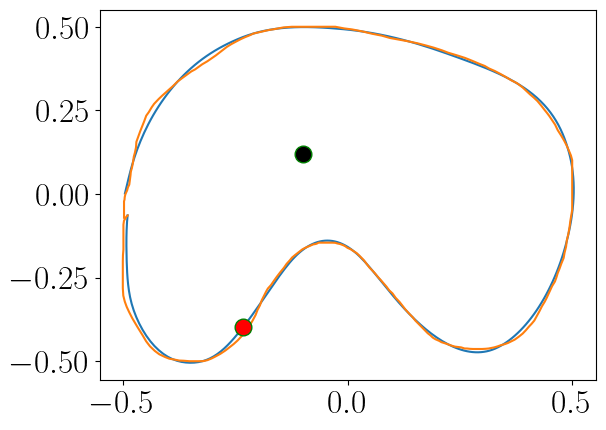

In [32]:
# @title
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size': 24}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

switch_ind = 50
dirt = jnp.array([-0.1, 0.12])

ts_new = 0.965*ts

indx=0
model_y = model_load(ts_new, traj_all_process[indx, 0, :])

plt.plot(model_y[:, 0], model_y[:, 1], label='Model')
plt.plot(traj_all_process[indx, :, 0], traj_all_process[indx, :, 1], label='Demo')
plt.plot(model_y[switch_ind, 0], model_y[switch_ind, 1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='r')
plt.plot(dirt[0], dirt[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='black')
# plt.legend()

## Animated trajectory

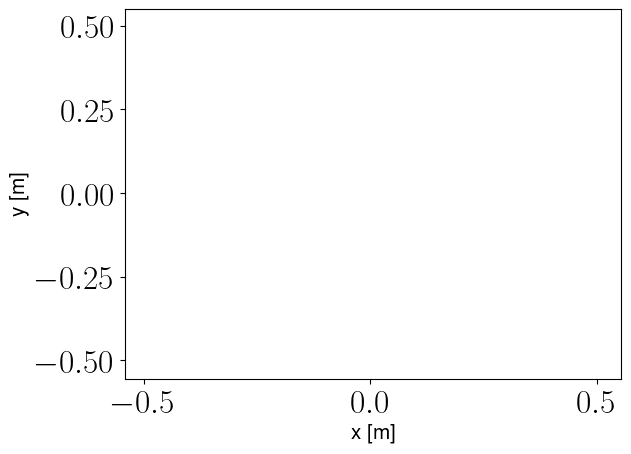

In [ ]:
# @title
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
%matplotlib inline


# Set up the graph using Matplotlib
fig, ax = plt.subplots()
# ax.set(xlim=(-60, 20), ylim=(-15, 25))
ax.set_ylabel('y [m]', fontsize=15)
ax.set_xlabel('x [m]', fontsize=15)
# ax.get_xaxis().set_label_coords(0.5, 0.12)

# Initiate camera
camera = Camera(fig)

# Create individual frames
for j in range(1, model_y.shape[0], 10):

    # Projectile's trajectory
    x = model_y[0:j, 0]
    y = model_y[0:j, 1]

    # Show Projectile's location
    ax.plot(x[-1], y[-1], marker='o', markersize=12, markeredgecolor='r', markerfacecolor='r')

    # Show Projectile's trajectory
    ax.plot(x, y, color='b', lw=2, linestyle='--')

    s = "t: " + str(j)

    ax.text(0.6, 0.8, s, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    # Capture frame
    camera.snap()

# Create animation
anim = camera.animate(interval = 100, repeat = True, repeat_delay = 5000)

# Inline display
HTML(anim.to_html5_video())

## Nominal implementation

In [ ]:
# @title
ys = traj_all_process
indx = 0
x = ys[indx,0,:]
f = lambda z : model_load.func(_, z, _)
# fx = jax.vmap(f)(x)
xall = jnp.expand_dims(ys[indx,0,:] ,axis=0)

xref = model_load(ts_new, ys[indx, 0, :])

switch_pos_ref = xref[switch_ind]

i=0

N = 1 # horizon

switch_flag = 0
vopt_bound = 1000
epsilon_B = 0.005 # STL -> CBF
epsilon_margin = 0.05
init_ball = (np.linalg.norm(switch_pos_ref - dirt)+epsilon_margin)**2
k = init_ball - epsilon_B**2
sampling_ts = jnp.mean(jnp.diff(ts_new))

dti = 0.5*sampling_ts

end_time = 1800*dti
current_time = 0

t_star = 100*dti
switch_CBF = 0

t_star_CBF = 100*dti

epsilon_B_target = epsilon_margin

B_all = []
vopt_all = []
cmd_vel = []
dB_dt_all = []
alpha_BB_all = []
dB_dt_alpha_B_all = []
dB_dx_all = []
gamma_t_all = []

dirt_t = 0
nominal_t = 0

STL = []
CBF = []
xref_all=[]
constraint_all = []
rad_B = []
alpha_all=[]

cmd_vel_prevs=0.0*f(x)
vopt_prevs=0.0*f(x)

vopt_analytical_all = []

alpha_B = 1
while(current_time < end_time):

  current_time += dti

  i += 1

  x1=np.asarray(x)

  tsi = jnp.array([0, dti])

  closest_ind = np.argmin(np.linalg.norm(xref - x1, axis=1))

  go_to_ind = closest_ind + N
  if go_to_ind + N >= xref.shape[0]:
    go_to_ind = 0

  xref_t = xref[go_to_ind]

  fx1 = np.asarray(f(x1))
  fxref_t = np.asarray(f(xref_t))

  Q = np.eye(x1.shape[0])
  vopt = cp.Variable(x1.shape[0])
  ## CLF
  # G_v = 2*((x1-xref_t).T)
  # alpha_v = 10
  # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
  # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
  # B_all.append(0)
  # rad_B.append(0)
  # dB_dt_all.append(0)
  # dB_dx_all.append(0)
  # dB_dt_alpha_B_all.append(0)
  # alpha_BB_all.append(0)
  # gamma_t_all.append(0)
  # alpha_all.append(alpha_v)
  ## CBF
  # alpha_B = 10
  B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
  # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
  dB_dx = -2*(x1 - xref_t).T
  alpha_BB = alpha_B*B**2
  constraints = [dB_dx@(fx1 - fxref_t + vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
  B_all.append(B)
  rad_B.append(np.sqrt(epsilon_B_target**2))
  dB_dt = 0.0
  dB_dt_all.append(dB_dt)
  dB_dx_all.append(dB_dx)
  dB_dt_alpha_B_all.append(-alpha_BB)
  alpha_BB_all.append(-alpha_BB)
  gamma_t_all.append(0)
  alpha_all.append(alpha_B)
  if dB_dx @ (fx1 - fxref_t) + dB_dt >= -alpha_BB:
    vopt_analytical = 0.0*fx1
  else:
    vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
  vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
  penalty_cmd_vel = 0.0

  prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + penalty_cmd_vel),
                    constraints)

  prob.solve()

  f1 = lambda z : model_load.func(_, z,_) + vopt.value

  xnext = f1(x)*dti + x
  # xnext = (fx1 + vopt_analytical)*dti + x

  cmd_vel_prevs = f1(x)
  # cmd_vel_prevs = fx1 + vopt_analytical
  cmd_vel.append(jnp.linalg.norm(cmd_vel_prevs))
  vopt_prevs = vopt.value
  # cmd_vel.append(jnp.linalg.norm(fx1 + vopt_analytical))
  vopt_all.append(jnp.linalg.norm(vopt_prevs))

  #xnext = solution.ys[-1,:]

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  xref_all.append(xref_t)

  x = xnext

  if(i%100==0):
    print(f"Time: {current_time}, Position: {x}")

## CBF implementation at inference: STL with **smooth switching**



In [ ]:
# @title
ys = traj_all_process
indx = 0
x = ys[indx,0,:]
f = lambda z : model_load.func(_, z, _)
# fx = jax.vmap(f)(x)
xall = jnp.expand_dims(ys[indx,0,:] ,axis=0)

xref = model_load(ts_new, ys[indx, 0, :])

switch_pos_ref = xref[switch_ind]

i=0

N = 1 # horizon

switch_flag = 0
vopt_bound = 1000
epsilon_B = 0.05 # STL -> CBF
epsilon_margin = 0.03

sampling_ts = jnp.mean(jnp.diff(ts_new))

dti = 0.4*sampling_ts

end_time = 2500*dti
current_time = 0

t_star = 90*dti
switch_CBF = 0

t_star_CBF = 90*dti

epsilon_margin_target = 0.01
epsilon_B_target = epsilon_B + epsilon_margin_target

B_all = []
vopt_all = []
cmd_vel = []
dB_dt_all = []
alpha_BB_all = []
dB_dt_alpha_B_all = []
dB_dx_all = []
gamma_t_all = []

dirt_t = 0
nominal_t = 0

STL = []
CBF = []
xref_all=[]
constraint_all = []
rad_B = []
alpha_all=[]

cmd_vel_prevs=0.0*f(x)
vopt_prevs=0.0*f(x)

vopt_analytical_all = []

alpha_B = 1
while(current_time < end_time):

  current_time += dti

  i += 1

  x1=np.asarray(x)

  tsi = jnp.array([0, dti])

  closest_ind = np.argmin(np.linalg.norm(xref - x1, axis=1))

  go_to_ind = closest_ind + N
  if go_to_ind + N >= xref.shape[0]:
    go_to_ind = 0

  xref_t = xref[go_to_ind]

  fx1 = np.asarray(f(x1))
  fxref_t = np.asarray(f(xref_t))

  Q = np.eye(x1.shape[0])
  vopt = cp.Variable(x1.shape[0])

  if (np.linalg.norm(switch_pos_ref - x1) < (epsilon_B) and switch_flag == 0) or (switch_flag == 1):
    if np.linalg.norm(dirt - x1)<(epsilon_B + epsilon_margin_target):
      print("Stop STL!")
      switch_CBF = 1
      switch_flag = 0
      nominal_t = 0
      ## CBF
      # alpha_B = 10
      # gamma_t = init_ball * (1 - dirt_t/t_star)
      # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
      xref_t_switch = xref_t
      init_ball_CBF = (xref_t_switch - dirt).T  @ (xref_t_switch - dirt)
      k_CBF = init_ball_CBF - epsilon_B**2
      gamma_t = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))
      B = epsilon_B**2 - (x1 - xref_t).T @ (x1 - xref_t) + gamma_t
      # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
      dB_dx = -2*(x1 - xref_t).T
      # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
      dB_dt = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))*(-1/t_star_CBF)
      alpha_B = (-dB_dx @ (cmd_vel_prevs - fxref_t) - dB_dt)/B
      alpha_B_switch = alpha_B
      alpha_BB = alpha_B*B
      # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - (init_ball) * np.exp(-(dirt_t/t_star)) * (-1/t_star)
      # constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      B_all.append(B)
      rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
      dB_dt_all.append(dB_dt)
      dB_dx_all.append(dB_dx)
      dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
      alpha_BB_all.append(-alpha_BB)
      gamma_t_all.append(gamma_t)
      alpha_all.append(alpha_B)
      # if dB_dx @ (fx1 - fxref_t) + dB_dt >= -alpha_BB:
      #   vopt_analytical = 0.0*fx1
      # else:
      #   vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical = cmd_vel_prevs - fx1
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      # penalty_cmd_vel = 0.0

      ## CLF
      # dV_de = 2*((x1-xref_t).T)
      # V = ((x1-xref_t).T)@(x1-xref_t)
      # # alpha_v = 10/(1 + 20*np.exp(-10/np.linalg.norm(x1-xref_t)))
      # # alpha_v = 10
      # # h_v = -dV_de@(fx1 - fxref_t)) - alpha_v*(V)
      # # constraints = [dV_de @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      # # penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
      # alpha_v = (-dV_de@(cmd_vel_prevs + fxref_t))/V
      # alpha_v_switch = alpha_v
      # B_all.append(0)
      # rad_B.append(0)
      # dB_dt_all.append(0)
      # dB_dx_all.append(0)
      # dB_dt_alpha_B_all.append(0)
      # alpha_BB_all.append(0)
      # gamma_t_all.append(0)
    else:
      if switch_flag == 1:
        dirt_t += dti
        # alpha_B = 10
        # gamma_t = init_ball * (1 - dirt_t/t_star)
        # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
        gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
        B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
        dB_dx = -2*(x1 - dirt).T
        # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
        dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
        alpha_BB = alpha_B*B**1
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - (init_ball) * np.exp(-(dirt_t/t_star)) * (-1/t_star)
        constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
        alpha_all.append(alpha_B)
        if dB_dx @ (fx1) + dB_dt >= -alpha_BB:
          vopt_analytical = 0.0*fx1
        else:
          vopt_analytical= (-dB_dx @ (fx1) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
        vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
        # penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 100*Q)

      else:
        print("Start STL!")
        dirt_t = 0
        switch_flag = 1
        # dirt_t += dti
        # alpha_B = 10
        # gamma_t = init_ball * (1 - dirt_t/t_star)
        # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
        xref_t_switch_1 = xref_t
        init_ball = (np.linalg.norm(xref_t_switch_1 - dirt))**2 + 16*epsilon_B**2
        k = init_ball - epsilon_B**2
        gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
        B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
        dB_dx = -2*(x1 - dirt).T
        # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
        dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
        # constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
        alpha_B = (-dB_dx @ (cmd_vel_prevs) - dB_dt)/B
        alpha_BB = alpha_B*B**1
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
        alpha_all.append(alpha_B)
        if dB_dx @ (fx1) + dB_dt >= -alpha_BB:
          print("Yes! zero vopt at switch")
          vopt_analytical = 0.0*fx1
        else:
          vopt_analytical= (-dB_dx @ (fx1) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
        vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
        penalty_cmd_vel = 0.0

  elif switch_CBF == 1:
    if nominal_t == 0:
      print("Start target!")
      nominal_t += dti
    elif np.linalg.norm(xref[closest_ind] - x1)<(epsilon_B + epsilon_margin_target):
      print("Stop target!")
      switch_CBF = 0
      ## CLF
      # G_v = 2*((x1-xref_t).T)
      # alpha_v = 10
      # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
      # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      # B_all.append(0)
      # rad_B.append(0)
      # dB_dt_all.append(0)
      # dB_dx_all.append(0)
      # dB_dt_alpha_B_all.append(0)
      # alpha_BB_all.append(0)
      # gamma_t_all.append(0)
      # alpha_all.append(alpha_v)
      ## CBF
      # alpha_B = 300
      B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
      dB_dx = -2*(x1 - xref_t).T
      alpha_BB = alpha_B*B
      constraints = [dB_dx@(fx1 - fxref_t + vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      B_all.append(B)
      rad_B.append(np.sqrt(epsilon_B**2))
      dB_dt = 0.0
      dB_dt_all.append(dB_dt)
      dB_dx_all.append(dB_dx)
      dB_dt_alpha_B_all.append(-alpha_BB)
      alpha_BB_all.append(-alpha_BB)
      gamma_t_all.append(0)
      alpha_all.append(alpha_B)
      penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
      if dB_dx @ (fx1 - fxref_t) + dB_dt >= -alpha_BB:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 10*Q)

    else:
      nominal_t += dti

    ## CBF
    # alpha_B = 10
    # gamma_t = init_ball * (1 - dirt_t/t_star)
    # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
    # xref_t = xref_t_switch
    gamma_t = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))
    B = epsilon_B**2 - (x1 - xref_t).T @ (x1 - xref_t) + gamma_t
    # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
    dB_dx = -2*(x1 - xref_t).T
    # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
    dB_dt = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))*(-1/t_star_CBF)
    alpha_BB = alpha_B*B
    # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - (init_ball) * np.exp(-(dirt_t/t_star)) * (-1/t_star)
    constraints = [dB_dx@(fx1 + vopt - fxref_t) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    B_all.append(B)
    rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
    dB_dt_all.append(dB_dt)
    dB_dx_all.append(dB_dx)
    dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
    alpha_BB_all.append(-alpha_BB)
    gamma_t_all.append(gamma_t)
    alpha_all.append(alpha_B)
    if dB_dx @ (fx1 - fxref_t) + dB_dt >= -alpha_BB:
      vopt_analytical = 0.0*fx1
    else:
      vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
    vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
    penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 10*Q)

    ## CLF: dist_to_target slope
    # G_v = 2*((x1-xref_t).T)
    # # alpha_v = 10/(1 + 20*np.exp(-10/np.linalg.norm(x1-xref_t)))
    # # alpha_v = 10
    # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(0)
    # rad_B.append(0)
    # dB_dt_all.append(0)
    # dB_dx_all.append(0)
    # dB_dt_alpha_B_all.append(0)
    # alpha_BB_all.append(0)
    # gamma_t_all.append(0)

    ## Approximate minimum: log sum exp

    ## CLF: Penalty on control input
    # G_v = 2*((x1-xref_t).T)
    # # alpha_v = 0.1/(1+np.exp(-np.linalg.norm(x1-xref_t)))
    # alpha_v = 10
    # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(0)
    # rad_B.append(0)
    # dB_dt_all.append(0)
    # dB_dx_all.append(0)
    # dB_dt_alpha_B_all.append(0)
    # alpha_BB_all.append(0)
    # gamma_t_all.append(0)
  else:
    ## CLF
    # G_v = 2*((x1-xref_t).T)
    # alpha_v = 10
    # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(0)
    # rad_B.append(0)
    # dB_dt_all.append(0)
    # dB_dx_all.append(0)
    # dB_dt_alpha_B_all.append(0)
    # alpha_BB_all.append(0)
    # gamma_t_all.append(0)
    # alpha_all.append(alpha_v)
    ## CBF
    # alpha_B = 10
    B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
    # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
    dB_dx = -2*(x1 - xref_t).T
    alpha_BB = alpha_B*B
    constraints = [dB_dx@(fx1 - fxref_t + vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    B_all.append(B)
    rad_B.append(np.sqrt(epsilon_B_target**2))
    dB_dt = 0.0
    dB_dt_all.append(dB_dt)
    dB_dx_all.append(dB_dx)
    dB_dt_alpha_B_all.append(-alpha_BB)
    alpha_BB_all.append(-alpha_BB)
    gamma_t_all.append(0)
    alpha_all.append(alpha_B)
    if dB_dx @ (fx1 - fxref_t) + dB_dt >= -alpha_BB:
      vopt_analytical = 0.0*fx1
    else:
      vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
    vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
    penalty_cmd_vel = 0.0

  if (dirt_t == 0 and switch_flag == 1) or (nominal_t == 0 and switch_CBF == 1):
    if (dirt_t == 0 and switch_flag == 1):
      print("STL switch")
    elif (nominal_t == 0 and switch_CBF == 1):
      print("CBF switch")
    xnext = cmd_vel_prevs*dti + x
    # xnext = (fx1 + vopt_analytical)*dti + x
    # cmd_vel.append(jnp.linalg.norm(fx1 + vopt_analytical))
    cmd_vel.append(jnp.linalg.norm(cmd_vel_prevs))
    vopt_all.append(jnp.linalg.norm(vopt_prevs))
  else:
    prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + penalty_cmd_vel),
                      constraints)

    prob.solve()

    f1 = lambda z : model_load.func(_, z,_) + vopt.value

    xnext = f1(x)*dti + x
    # xnext = (fx1 + vopt_analytical)*dti + x

    cmd_vel_prevs = f1(x)
    # cmd_vel_prevs = fx1 + vopt_analytical
    cmd_vel.append(jnp.linalg.norm(cmd_vel_prevs))
    vopt_prevs = vopt.value
    # cmd_vel.append(jnp.linalg.norm(fx1 + vopt_analytical))
    vopt_all.append(jnp.linalg.norm(vopt_prevs))

  #xnext = solution.ys[-1,:]

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  STL.append(switch_flag)
  CBF.append(switch_CBF)
  xref_all.append(xref_t)

  x = xnext

  close_to_goal = np.linalg.norm(x - xref[-1])

  if(i%100==0):
    print(f"Time: {current_time}, Position: {x}")

Time: 0.12909698486328125, Position: [-0.29312053 -0.48786253]
Start STL!
Yes! zero vopt at switch
STL switch
Stop STL!
CBF switch
Start target!
Time: 0.2581946849822998, Position: [-0.74326104  9.88768   ]
Time: 0.38729238510131836, Position: [-1.3817828  9.706098 ]
Time: 0.5163900852203369, Position: [-1.9808649  9.400796 ]
Time: 0.6454877853393555, Position: [-2.5301187  8.9511795]
Time: 0.774585485458374, Position: [-3.027122  8.4103  ]
Time: 0.9036831855773926, Position: [-3.4743972  7.9281974]
Time: 1.032779335975647, Position: [-3.8791041  7.43941  ]
Time: 1.161871075630188, Position: [-4.241536   6.8741646]
Time: 1.290962815284729, Position: [-4.5724335  6.2530427]
Time: 1.42005455493927, Position: [-4.883526   5.5919704]
Time: 1.549146294593811, Position: [-5.181644   4.8980317]
Time: 1.678238034248352, Position: [-5.4690537  4.1755996]
Time: 1.807329773902893, Position: [-5.7454357  3.429854 ]
Time: 1.936421513557434, Position: [-6.0078673  2.6689067]
Time: 2.065519332885742,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-cd0679bb39a6>", line 366, in <cell line: 62>
    prob.solve()
  File "/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py", line 495, in solve
    return solve_func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py", line 1056, in _solve
    data, solving_chain, inverse_data = self.get_problem_data(
  File "/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py", line 683, in get_problem_data
    data, inverse_data = solving_chain.apply(self, verbose)
  File "/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/chain.py", line 76, in apply
    problem, inv = r.apply(problem)
  File "/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/qp2quad_form/qp_matrix_stuffing.py", line 245, in apply


TypeError: object of type 'NoneType' has no len()

## CBF implementation at inference: STL with **smooth switching: relax constraint**

In [ ]:
# @title
ys = traj_test
indx = 0
x = ys[indx,0,:]
model_load = model_load_1
f = lambda z : model_load.func(_, z, _)
# fx = jax.vmap(f)(x)
xall = jnp.expand_dims(ys[indx,0,:] ,axis=0)
ts = tn
xref = model_load(ts, ys[indx, 0, :])

close_to_goal = np.linalg.norm(x - xref[-1])

i=0

N = 5 # horizon

switch_flag = 0
vopt_bound = 1000
epsilon_B = 0.5 # STL -> CBF
epsilon_margin = 0.5
init_ball = 15**2
k = init_ball - epsilon_B**2
sampling_ts = jnp.mean(jnp.diff(ts))
dti = 0.5*sampling_ts
t_star = 70*dti
switch_CBF = 0

t_star_CBF = 100*dti
init_ball_CBF = 12**2
k_CBF = init_ball_CBF - epsilon_B**2

epsilon_B_target = 1

switch_pos_ref = xref[switch_ind]

B_all = []
vopt_all = []
cmd_vel = []
dB_dt_all = []
alpha_BB_all = []
dB_dt_alpha_B_all = []
dB_dx_all = []
gamma_t_all = []

dirt_t = 0
nominal_t = 0

STL = []
CBF = []
xref_all=[]
constraint_all = []
rad_B = []
alpha_all=[]

cmd_vel_prevs=0.0*f(x)

while(close_to_goal > 0.01):

  i += 1

  x1=np.asarray(x)

  tsi = jnp.array([0, dti])

  closest_ind = np.argmin(np.linalg.norm(xref - x1, axis=1))

  go_to_ind = np.clip(closest_ind + N, 0, xref.shape[0])

  xref_t = xref[go_to_ind]

  fx1 = np.asarray(f(x1))
  fxref_t = np.asarray(f(xref_t))

  Q = np.eye(x1.shape[0])
  vopt = cp.Variable(x1.shape[0])

  if (np.linalg.norm(switch_pos_ref - x1) < 0.1 and switch_flag == 0) or (switch_flag == 1):
    if np.linalg.norm(dirt - x1)<(epsilon_B + epsilon_margin):
      print("Stop STL!")
      switch_CBF = 1
      switch_flag = 0
      nominal_t = 0
      ## CBF
      # alpha_B = 10
      # gamma_t = init_ball * (1 - dirt_t/t_star)
      # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
      xref_t_switch = xref_t
      gamma_t = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))
      B = epsilon_B**2 - (x1 - xref_t).T @ (x1 - xref_t) + gamma_t
      dB_dx = -2*(x1 - xref_t).T
      # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
      dB_dt = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))*(-1/t_star_CBF)
      # alpha_B = (-dB_dx @ (cmd_vel_prevs - fxref_t) - dB_dt)/B
      alpha_B = 7
      alpha_B_switch = alpha_B
      alpha_BB = alpha_B*B
      B_all.append(B)
      rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
      dB_dt_all.append(dB_dt)
      dB_dx_all.append(dB_dx)
      dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
      alpha_BB_all.append(-alpha_BB)
      gamma_t_all.append(gamma_t)
      alpha_all.append(alpha_B)
      # dirt CBF
      epsilon_d = cp.Variable(1)
      gamma_t_d = (k) * (np.exp(-(dirt_t/t_star)))
      B_d = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t_d
      dB_dx_d = -2*(x1 - dirt).T
      # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
      dB_dt_d = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
      alpha_B_d = 10
      alpha_BB_d = alpha_B_d*B_d
      constraints = [dB_dx_d@(fx1 + vopt) + dB_dt_d >= -alpha_BB_d - epsilon_d,
                     dB_dx@(fx1 + vopt - fxref_t) + dB_dt >= -alpha_BB,
                     fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]

      ## CLF
      # dV_de = 2*((x1-xref_t).T)
      # V = ((x1-xref_t).T)@(x1-xref_t)
      # # alpha_v = 10/(1 + 20*np.exp(-10/np.linalg.norm(x1-xref_t)))
      # # alpha_v = 10
      # # h_v = -dV_de@(fx1 - fxref_t)) - alpha_v*(V)
      # # constraints = [dV_de @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      # # penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
      # alpha_v = (-dV_de@(cmd_vel_prevs + fxref_t))/V
      # alpha_v_switch = alpha_v
      # B_all.append(0)
      # rad_B.append(0)
      # dB_dt_all.append(0)
      # dB_dx_all.append(0)
      # dB_dt_alpha_B_all.append(0)
      # alpha_BB_all.append(0)
      # gamma_t_all.append(0)
    else:
      if switch_flag == 1:
        dirt_t += dti
        # alpha_B = 10
        # gamma_t = init_ball * (1 - dirt_t/t_star)
        # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
        gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
        B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
        dB_dx = -2*(x1 - dirt).T
        # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
        dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
        alpha_BB = alpha_B*B**1
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - (init_ball) * np.exp(-(dirt_t/t_star)) * (-1/t_star)
        constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
        alpha_all.append(alpha_B)
      else:
        print("Start STL!")
        dirt_t = 0
        switch_flag = 1
        # dirt_t += dti
        # alpha_B = 10
        # gamma_t = init_ball * (1 - dirt_t/t_star)
        # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
        gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
        B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
        dB_dx = -2*(x1 - dirt).T
        # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
        dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
        # constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
        alpha_B = (-dB_dx @ (cmd_vel_prevs) - dB_dt)/B
        alpha_BB = alpha_B*B**1
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
        alpha_all.append(alpha_B)
  elif switch_CBF == 1:
    if nominal_t == 0:
      print("Start target!")
      nominal_t += dti
    elif np.linalg.norm(xref[closest_ind] - x1)<(epsilon_B + epsilon_margin):
      print("Stop target!")
      switch_CBF = 0
      ## CLF
      G_v = 2*((x1-xref_t).T)
      alpha_v = 10
      h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
      constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      B_all.append(0)
      rad_B.append(0)
      dB_dt_all.append(0)
      dB_dx_all.append(0)
      dB_dt_alpha_B_all.append(0)
      alpha_BB_all.append(0)
      gamma_t_all.append(0)
      alpha_all.append(alpha_v)
      ## CBF
      # # alpha_B = 300
      # B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
      # dB_dx = -2*(x1 - xref_t).T
      # alpha_BB = alpha_B*B
      # constraints = [dB_dx@(fx1 - fxref_t+ vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      # B_all.append(B)
      # rad_B.append(np.sqrt(epsilon_B**2))
      # dB_dt_all.append(0)
      # dB_dx_all.append(dB_dx)
      # dB_dt_alpha_B_all.append(-alpha_BB)
      # alpha_BB_all.append(-alpha_BB)
      # gamma_t_all.append(0)
      # penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
    else:
      nominal_t += dti
    ## CBF
    # alpha_B = 10
    # gamma_t = init_ball * (1 - dirt_t/t_star)
    # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
    gamma_t = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))
    B = epsilon_B**2 - (x1 - xref_t).T @ (x1 - xref_t) + gamma_t
    dB_dx = -2*(x1 - xref_t).T
    # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
    dB_dt = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))*(-1/t_star_CBF)
    # alpha_B = (-dB_dx @ (cmd_vel_prevs - fxref_t) - dB_dt)/B
    alpha_B = 7
    alpha_B_switch = alpha_B
    alpha_BB = alpha_B*B
    B_all.append(B)
    rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
    dB_dt_all.append(dB_dt)
    dB_dx_all.append(dB_dx)
    dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
    alpha_BB_all.append(-alpha_BB)
    gamma_t_all.append(gamma_t)
    alpha_all.append(alpha_B)
    # dirt CBF
    epsilon_d = cp.Variable(1)
    gamma_t_d = (k) * (np.exp(-(dirt_t/t_star)))
    B_d = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t_d
    dB_dx_d = -2*(x1 - dirt).T
    # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
    dB_dt_d = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
    alpha_B_d = 10
    alpha_BB_d = alpha_B_d*B_d
    constraints = [dB_dx_d@(fx1 + vopt) + dB_dt_d >= -alpha_BB_d - epsilon_d,
                    dB_dx@(fx1 + vopt - fxref_t) + dB_dt >= -alpha_BB,
                    fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    B_all.append(B)
    rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
    dB_dt_all.append(dB_dt)
    dB_dx_all.append(dB_dx)
    dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
    alpha_BB_all.append(-alpha_BB)
    gamma_t_all.append(gamma_t)
    alpha_all.append(alpha_B)

    ## CLF: dist_to_target slope
    # G_v = 2*((x1-xref_t).T)
    # # alpha_v = 10/(1 + 20*np.exp(-10/np.linalg.norm(x1-xref_t)))
    # # alpha_v = 10
    # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(0)
    # rad_B.append(0)
    # dB_dt_all.append(0)
    # dB_dx_all.append(0)
    # dB_dt_alpha_B_all.append(0)
    # alpha_BB_all.append(0)
    # gamma_t_all.append(0)

    ## Approximate minimum: log sum exp

    ## CLF: Penalty on control input
    # G_v = 2*((x1-xref_t).T)
    # # alpha_v = 0.1/(1+np.exp(-np.linalg.norm(x1-xref_t)))
    # alpha_v = 10
    # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(0)
    # rad_B.append(0)
    # dB_dt_all.append(0)
    # dB_dx_all.append(0)
    # dB_dt_alpha_B_all.append(0)
    # alpha_BB_all.append(0)
    # gamma_t_all.append(0)
    penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
  else:
    ## CLF
    G_v = 2*((x1-xref_t).T)
    alpha_v = 10
    h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    B_all.append(0)
    rad_B.append(0)
    dB_dt_all.append(0)
    dB_dx_all.append(0)
    dB_dt_alpha_B_all.append(0)
    alpha_BB_all.append(0)
    gamma_t_all.append(0)
    alpha_all.append(alpha_v)
    ## CBF
    # alpha_B = 10
    # B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
    # # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
    # dB_dx = -2*(x1 - xref_t).T
    # alpha_BB = alpha_B*B
    # constraints = [dB_dx@(fx1 - fxref_t + vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(B)
    # rad_B.append(np.sqrt(epsilon_B_target**2))
    # dB_dt_all.append(0)
    # dB_dx_all.append(dB_dx)
    # dB_dt_alpha_B_all.append(-alpha_BB)
    # alpha_BB_all.append(-alpha_BB)
    # gamma_t_all.append(0)
    penalty_cmd_vel = 0.0
  if (dirt_t == 0 and switch_flag == 1):
      print("STL switch")
  else:
    if switch_CBF == 1:
      print("CBF switch")
      prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + 0.1*epsilon_d**2),
                      constraints)
    else:

      prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + penalty_cmd_vel),
                      constraints)

    prob.solve()

    f1 = lambda z : model_load.func(_, z,_) + vopt.value

    xnext = f1(x)*dti + x

    cmd_vel_prevs = f1(x)
    cmd_vel.append(jnp.linalg.norm(cmd_vel_prevs))

  #xnext = solution.ys[-1,:]

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  STL.append(switch_flag)
  CBF.append(switch_CBF)
  xref_all.append(xref_t)

  x = xnext

  close_to_goal = np.linalg.norm(x - xref[-1])

  if(i%100==0):
    print(f"Time: {i}, Position: {x}")

## CBF implementation at inference: STL with **low pass filter**

In [ ]:
# @title
import scipy.signal

ys = traj_test
indx = 0
x = ys[indx,0,:]
model_load = model_load_1
f = lambda z : model_load.func(_, z, _)
# fx = jax.vmap(f)(x)
xall = jnp.expand_dims(ys[indx,0,:] ,axis=0)
ts = tn
xref = model_load(ts, ys[indx, 0, :])

close_to_goal = np.linalg.norm(x - xref[-1])

i=0

N = 5 # horizon

switch_flag = 0
vopt_bound = 1000
epsilon_B = 0.5 # STL -> CBF
epsilon_margin = 0.5
init_ball = 15**2
k = init_ball - epsilon_B**2
sampling_ts = jnp.mean(jnp.diff(ts))
dti = 0.5*sampling_ts
fs = 1000
t_star = 70*dti
switch_CBF = 0

dirt_t = 0
nominal_t = 0

t_star_CBF = 50*dti
init_ball_CBF = 10**2
k_CBF = init_ball_CBF - epsilon_B**2

epsilon_B_target = 1

switch_pos_ref = xref[switch_ind]

B_all = []
vopt_all = []
cmd_vel = []
dB_dt_all = []
alpha_BB_all = []
dB_dt_alpha_B_all = []
dB_dx_all = []
gamma_t_all = []

STL = []
CBF = []
xref_all=[]
constraint_all = []
rad_B = []

cmd_vel_prevs=0.0*f(x)

filter_order = 4

cmd_vel_filter = filter_order*[cmd_vel_prevs]

b_filter, a_filter = scipy.signal.iirfilter(filter_order, Wn=399, fs=fs, btype="low", ftype="butter")

while(close_to_goal > 0.01):

  x1=np.asarray(x)

  tsi = jnp.array([0, dti])

  closest_ind = np.argmin(np.linalg.norm(xref - x1, axis=1))

  go_to_ind = np.clip(closest_ind + N, 0, xref.shape[0])

  xref_t = xref[go_to_ind]

  fx1 = np.asarray(f(x1))
  fxref_t = np.asarray(f(xref_t))

  Q = np.eye(x1.shape[0])
  vopt = cp.Variable(x1.shape[0])

  if (np.linalg.norm(switch_pos_ref - x1) < 0.1 and switch_flag == 0) or (switch_flag == 1):
    if np.linalg.norm(dirt - x1)<(epsilon_B + epsilon_margin):
      print("Stop STL!")
      switch_CBF = 1
      switch_flag = 0
      nominal_t = 0
      ## CBF
      # # alpha_B = 10
      # # gamma_t = init_ball * (1 - dirt_t/t_star)
      # # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
      # gamma_t = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))
      # B = epsilon_B**2 - (x1 - xref_t).T @ (x1 - xref_t) + gamma_t
      # # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
      # dB_dx = -2*(x1 - xref_t).T
      # # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
      # dB_dt = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))*(-1/t_star_CBF)
      # alpha_B = (-dB_dx @ (cmd_vel_prevs-fxref_t) - dB_dt)/B
      # alpha_BB = alpha_B*B
      # # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - (init_ball) * np.exp(-(dirt_t/t_star)) * (-1/t_star)
      # # constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      # B_all.append(B)
      # rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
      # dB_dt_all.append(dB_dt)
      # dB_dx_all.append(dB_dx)
      # dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
      # alpha_BB_all.append(-alpha_BB)
      # gamma_t_all.append(gamma_t)

      ## CLF
      dV_de = 2*((x1-xref_t).T)
      V = ((x1-xref_t).T)@(x1-xref_t)
      # alpha_v = 10/(1 + 20*np.exp(-10/np.linalg.norm(x1-xref_t)))
      # alpha_v = 10
      # h_v = -dV_de@(fx1 - fxref_t)) - alpha_v*(V)
      # constraints = [dV_de @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      # penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
      alpha_v = (-dV_de@(cmd_vel_prevs + fxref_t))/V
      alpha_v_switch = alpha_v
      B_all.append(0)
      rad_B.append(0)
      dB_dt_all.append(0)
      dB_dx_all.append(0)
      dB_dt_alpha_B_all.append(0)
      alpha_BB_all.append(0)
      gamma_t_all.append(0)
    else:
      if switch_flag == 1:
        dirt_t += dti
        # alpha_B = 10
        # gamma_t = init_ball * (1 - dirt_t/t_star)
        # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
        gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
        B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
        dB_dx = -2*(x1 - dirt).T
        # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
        dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
        alpha_BB = alpha_B*B**1
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - (init_ball) * np.exp(-(dirt_t/t_star)) * (-1/t_star)
        constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
      else:
        print("Start STL!")
        dirt_t = 0
        switch_flag = 1
        dirt_t += dti
        # alpha_B = 10
        # gamma_t = init_ball * (1 - dirt_t/t_star)
        # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
        gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
        B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
        # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
        dB_dx = -2*(x1 - dirt).T
        # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
        dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
        # constraints = [dB_dx@(fx1 + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
        alpha_B = (-dB_dx @ (cmd_vel_prevs) - dB_dt)/B
        alpha_BB = alpha_B*B**1
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
  elif switch_CBF == 1:
    if nominal_t == 0:
      print("Start target!")
      nominal_t += dti
    elif np.linalg.norm(xref[closest_ind] - x1)<(epsilon_B + epsilon_margin):
      print("Stop target!")
      switch_CBF = 0
      ## CLF
      G_v = 2*((x1-xref_t).T)
      alpha_v = 10
      h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
      constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      B_all.append(0)
      rad_B.append(0)
      dB_dt_all.append(0)
      dB_dx_all.append(0)
      dB_dt_alpha_B_all.append(0)
      alpha_BB_all.append(0)
      gamma_t_all.append(0)
      ## CBF
      # # alpha_B = 300
      # B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
      # dB_dx = -2*(x1 - xref_t).T
      # alpha_BB = alpha_B*B
      # constraints = [dB_dx@(fx1 - fxref_t+ vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      # B_all.append(B)
      # rad_B.append(np.sqrt(epsilon_B**2))
      # dB_dt_all.append(0)
      # dB_dx_all.append(dB_dx)
      # dB_dt_alpha_B_all.append(-alpha_BB)
      # alpha_BB_all.append(-alpha_BB)
      # gamma_t_all.append(0)
      # penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
    else:
      nominal_t += dti
    ## CBF
    # # alpha_B = 10
    # # gamma_t = init_ball * (1 - dirt_t/t_star)
    # # gamma_t = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))
    # gamma_t = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))
    # B = epsilon_B**2 - (x1 - xref_t).T @ (x1 - xref_t) + gamma_t
    # # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
    # dB_dx = -2*(x1 - xref_t).T
    # # dB_dt = (k/(1-np.exp(-1))) * (np.exp(-(dirt_t/t_star)) - np.exp(-1))*(-1/t_star)
    # dB_dt = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))*(-1/t_star_CBF)
    # alpha_BB = alpha_B*B
    # # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - (init_ball) * np.exp(-(dirt_t/t_star)) * (-1/t_star)
    # constraints = [dB_dx@(fx1 - fxref_t + vopt) + dB_dt >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(B)
    # rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
    # dB_dt_all.append(dB_dt)
    # dB_dx_all.append(dB_dx)
    # dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
    # alpha_BB_all.append(-alpha_BB)
    # gamma_t_all.append(gamma_t)

    ## CLF: dist_to_target slope
    G_v = 2*((x1-xref_t).T)
    # alpha_v = 10/(1 + 20*np.exp(-10/np.linalg.norm(x1-xref_t)))
    # alpha_v = 10
    h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    B_all.append(0)
    rad_B.append(0)
    dB_dt_all.append(0)
    dB_dx_all.append(0)
    dB_dt_alpha_B_all.append(0)
    alpha_BB_all.append(0)
    gamma_t_all.append(0)

    ## Approximate minimum: log sum exp

    ## CLF: Penalty on control input
    # G_v = 2*((x1-xref_t).T)
    # # alpha_v = 0.1/(1+np.exp(-np.linalg.norm(x1-xref_t)))
    # alpha_v = 10
    # h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    # constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(0)
    # rad_B.append(0)
    # dB_dt_all.append(0)
    # dB_dx_all.append(0)
    # dB_dt_alpha_B_all.append(0)
    # alpha_BB_all.append(0)
    # gamma_t_all.append(0)
    penalty_cmd_vel = cp.quad_form((vopt+fx1) - cmd_vel_prevs, 0*Q)
  else:
    ## CLF
    G_v = 2*((x1-xref_t).T)
    alpha_v = 10
    h_v = -2*(((x1-xref_t).T)@(fx1 - fxref_t)) - alpha_v*((((x1-xref_t).T)@(x1-xref_t)))
    constraints = [G_v @ vopt <= h_v, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    B_all.append(0)
    rad_B.append(0)
    dB_dt_all.append(0)
    dB_dx_all.append(0)
    dB_dt_alpha_B_all.append(0)
    alpha_BB_all.append(0)
    gamma_t_all.append(0)
    ## CBF
    # alpha_B = 10
    # B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
    # # h_B = 2*(((x1-dirt).T)@(fx1)) + alpha_B*(B) - init_ball/t_star
    # dB_dx = -2*(x1 - xref_t).T
    # alpha_BB = alpha_B*B
    # constraints = [dB_dx@(fx1 - fxref_t + vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
    # B_all.append(B)
    # rad_B.append(np.sqrt(epsilon_B_target**2))
    # dB_dt_all.append(0)
    # dB_dx_all.append(dB_dx)
    # dB_dt_alpha_B_all.append(-alpha_BB)
    # alpha_BB_all.append(-alpha_BB)
    # gamma_t_all.append(0)
    penalty_cmd_vel = 0.0
  if (dirt_t == 0 and switch_flag == 1) or (nominal_t == 0 and switch_CBF == 1):
    cmd_vel_t = cmd_vel_prevs
  else:
    prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + penalty_cmd_vel),
                      constraints)

    prob.solve()

    f1 = lambda z : model_load.func(_, z,_) + vopt.value
    cmd_vel_t = f1(x)

  if i==0:
    cmd_vel_filter = filter_order*[cmd_vel_t]
    cmd_vel_filtered_t = cmd_vel_t
  else:
    cmd_vel_filter.pop(0)
    cmd_vel_filter.insert(filter_order, cmd_vel_t)
    cmd_vel_filtered = scipy.signal.lfilter(b_filter, a_filter, np.array(cmd_vel_filter))
    cmd_vel_filtered_t = cmd_vel_filtered[-1]

  xnext = cmd_vel_filtered_t*dti + x

  cmd_vel_prevs = cmd_vel_t
  cmd_vel.append(jnp.linalg.norm(cmd_vel_t))
  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  STL.append(switch_flag)
  CBF.append(switch_CBF)
  xref_all.append(xref_t)

  x = xnext

  close_to_goal = np.linalg.norm(x - xref[-1])

  i += 1

  if(i%100==0):
    print(f"Time: {i}, Position: {x}")

## CBF implementation at inference: STL with **mixing**, without **fixed alpha**

In [ ]:
# @title
ys = traj_all_process
indx = 0
x = ys[indx,0,:]
xall = jnp.expand_dims(ys[indx,0,:], axis=0)
f = lambda z : model_load.func(_, z, _)
ts = ts_new
xref = model_load(ts, ys[indx, 0, :])

close_to_goal = np.linalg.norm(x - xref[-1])

i=0

N = 2 # horizon

dirt_sense = 0
wiped_dirt = 0
vopt_bound = 1000
epsilon_B = 0.05 # STL -> CBF
epsilon_margin = 0.01
sampling_ts = jnp.mean(jnp.diff(ts_new))
dti = 0.4*sampling_ts
t_star = 50*dti

near_target = 1
t_star_CBF = 50*dti

epsilon_margin_target = 0.01
epsilon_B_target = epsilon_B + epsilon_margin_target

switch_pos_ref = xref[switch_ind]

end_time = 1300*dti
current_time = 0

B_all = []
vopt_all = []
cmd_vel = []
dB_dt_all = []
alpha_BB_all = []
dB_dt_alpha_B_all = []
dB_dx_all = []
gamma_t_all = []

dirt_t = 0
nominal_t = 0

STL = []
CBF = []
xref_all=[]
constraint_all = []
rad_B = []
alpha_all=[]

cmd_vel_prevs=0.0*f(x)
vopt_prevs=0.0*f(x)

vopt_analytical_all = []

alpha_B = 5

beta_t = 0
dt_beta_t = 0.05
beta_t_all=[]

trans_period1 = 0
trans_period2 = 0

to_dirt = 0
back_to_target = 0

while(current_time < end_time):

  i += 1

  current_time += dti

  x1=np.asarray(x)

  tsi = jnp.array([0, dti])

  closest_ind = np.argmin(np.linalg.norm(xref - x1, axis=1))

  go_to_ind = closest_ind + N
  if go_to_ind + N >= xref.shape[0]:
    go_to_ind = 0

  xref_t = xref[go_to_ind]

  fx1 = np.asarray(f(x1))
  fxref_t = np.asarray(f(xref_t))

  Q = np.eye(x1.shape[0])
  vopt = cp.Variable(x1.shape[0])

  # sensing
  if dirt_sense == 0:
    dirt_sense = np.linalg.norm(switch_pos_ref - x1) < 0.1

  # Different modes
  if dirt_sense == 1:
    if dirt_t == 0:
      wiped_dirt = 0
      print('Start wiping dirt!')
      trans_period1 = 1
      init_ball = (np.linalg.norm(dirt - x1) + 0.05)**2
      k = init_ball - epsilon_B**2

    if wiped_dirt == 0:
      wiped_dirt = np.linalg.norm(dirt - x1)<(epsilon_B + epsilon_margin)

    if wiped_dirt==0 or trans_period1 or trans_period2:
      if trans_period2:
        gamma_t = epsilon_margin**2 + 2*epsilon_B*epsilon_margin
        dB_dt = 0.
      if trans_period1:
        beta_t = np.clip(beta_t + dt_beta_t, 0., 1.)
        if beta_t == 1.:
          trans_period1 = 0
      vopt1 = cp.Variable(x1.shape[0])
      gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
      B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
      dB_dx = -2*(x1 - dirt).T
      dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
      alpha_BB = alpha_B*B**1
      constraints = [dB_dx@(fx1 + vopt1) + dB_dt >= -alpha_BB, fx1 + vopt1<=vopt_bound, fx1 + vopt1>=-vopt_bound]
      prob1 = cp.Problem(cp.Minimize(cp.quad_form(vopt1, Q)),
                        constraints)
      prob1.solve()
      if wiped_dirt == 0:
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        alpha_all.append(alpha_B)

      if dB_dx @ (fx1) + dB_dt >= -alpha_BB:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx @ (fx1) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      dirt_t += dti

  if wiped_dirt == 1:
    if nominal_t == 0:
      print('Wiped dirt! going back to target!')
      trans_period2 = 1
      dirt_sense = 0
      dirt_t = 0.
      init_ball_CBF = (np.linalg.norm(xref_t - x1) + 0.05)**2
      k_CBF = init_ball_CBF - epsilon_B**2

    if trans_period2:
      beta_t = np.clip(beta_t - dt_beta_t, 0., 1.)
      if beta_t == 0.:
        trans_period2 = 0

    near_target = np.linalg.norm(xref_t - x1)<(epsilon_B)

    if near_target == 0:
      gamma_t_CBF = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))
      B_CBF = epsilon_B**2 - (x1 - xref_t).T @ (x1 - xref_t) + gamma_t_CBF
      dB_dx_CBF = -2*(x1 - xref_t).T
      dB_dt_CBF = (k_CBF) * (np.exp(-(nominal_t/t_star_CBF)))*(-1/t_star_CBF)
      alpha_BB_CBF = alpha_B*B_CBF
      constraints = [dB_dx_CBF@(fx1 + vopt - fxref_t) + dB_dt_CBF >= -alpha_BB_CBF,
                      fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)),
                        constraints)
      prob.solve()
      B_all.append(B_CBF)
      rad_B.append(np.sqrt(epsilon_B**2 + gamma_t_CBF))
      dB_dt_all.append(dB_dt_CBF)
      dB_dx_all.append(dB_dx_CBF)
      dB_dt_alpha_B_all.append(-alpha_BB_CBF-dB_dt_CBF)
      alpha_BB_all.append(-alpha_BB_CBF)
      gamma_t_all.append(gamma_t_CBF)
      alpha_all.append(alpha_B)
      if dB_dx_CBF @ (fx1 - fxref_t) + dB_dt_CBF >= -alpha_BB_CBF:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx_CBF @ (fx1 - fxref_t) - dB_dt_CBF - alpha_BB_CBF) * dB_dx_CBF.T/(dB_dx_CBF @ dB_dx_CBF.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      nominal_t += dti

  if near_target:
    if wiped_dirt == 1:
      wiped_dirt = 0
      nominal_t = 0.
    vopt = cp.Variable(x1.shape[0])
    B = epsilon_B_target**2 - (x1 - xref_t).T @ (x1 - xref_t)
    dB_dx = -2*(x1 - xref_t).T
    alpha_BB = alpha_B*B
    constraints = [dB_dx@(fx1 - fxref_t + vopt) >= -alpha_BB, fx1 + vopt<=vopt_bound,
                    fx1 + vopt>=-vopt_bound]

    prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)),
                      constraints)
    prob.solve()
    if beta_t == 0.0:
      B_all.append(B)
      rad_B.append(np.sqrt(epsilon_B_target**2))
      dB_dt = 0.0
      dB_dt_all.append(dB_dt)
      dB_dx_all.append(dB_dx)
      dB_dt_alpha_B_all.append(-alpha_BB)
      alpha_BB_all.append(-alpha_BB)
      gamma_t_all.append(0)
      alpha_all.append(alpha_B)
      if dB_dx @ (fx1 - fxref_t) + dB_dt >= -alpha_BB:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))

  if trans_period1:
    to_dirt = 1
    u1 = vopt.value # target
    u2 = vopt1.value # STL
    u_final = (1-beta_t)*u1 + beta_t*u2

  elif trans_period2:
    to_dirt = 0
    back_to_target = 1
    u1 = vopt.value # target CBF
    u2 = vopt1.value # STL
    u_final = (1-beta_t)*u1 + beta_t*u2

  else:
    if dirt_sense == 1 and wiped_dirt == 0:
      to_dirt = 1
      u_final = vopt1.value # STL
    elif wiped_dirt ==1 and near_target == 0:
      back_to_target = 1
      u_final = vopt.value # target CBF
    elif near_target == 1:
      back_to_target = 0
      u_final = vopt.value # target

  f1_final = f(x) + u_final

  xnext = f1_final*dti + x

  cmd_vel_prevs = f1_final
  cmd_vel.append(jnp.linalg.norm(cmd_vel_prevs))
  vopt_prevs = u_final
  vopt_all.append(jnp.linalg.norm(u_final))

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  STL.append(to_dirt)
  CBF.append(back_to_target)
  xref_all.append(xref_t)
  beta_t_all.append(beta_t)

  x = xnext

  close_to_goal = np.linalg.norm(x - xref[-1])

  if(i%100==0):
    print(f"Time: {i}, Position: {x}")

Time: 100, Position: [-0.3019894 -0.4945245]
Start wiping dirt!
Time: 200, Position: [-0.05577778 -0.0750711 ]
Wiped dirt! going back to target!
Time: 300, Position: [-0.09394488  0.07126677]
Time: 400, Position: [ 0.0653387  -0.17459929]
Time: 500, Position: [ 0.30118766 -0.44953346]
Time: 600, Position: [ 0.49725085 -0.03928012]
Time: 700, Position: [0.21976389 0.41986668]
Time: 800, Position: [-0.3330247   0.39533192]
Time: 900, Position: [-0.49963838 -0.01200016]
Time: 1000, Position: [-0.39729157 -0.50808495]
Start wiping dirt!
Time: 1100, Position: [-0.10474268 -0.16904172]
Wiped dirt! going back to target!
Time: 1200, Position: [-0.07072482  0.12448202]
Time: 1300, Position: [ 0.0096652  -0.08658752]


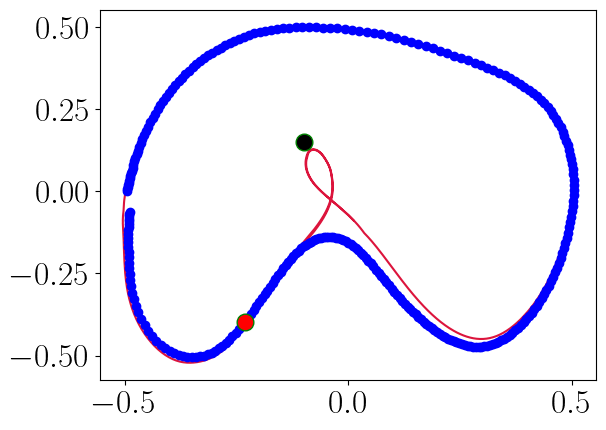

In [ ]:
font = {'size': 24}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

figure, axes = plt.subplots()
plt.plot(xall[:, 0], xall[:, 1], c="crimson", label="Inference")
model_y = model_load(ts_new, ys[0, 0])
plt.plot(xref[:, 0], xref[:, 1], 'o', c="blue", label="Model")
plt.plot(dirt[0], dirt[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='black')
plt.plot(switch_pos_ref[0], switch_pos_ref[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='red')
# plt.legend()
# plt.tight_layout()
plt.show()

## CBF, CLF implementation at inference: STL with **mixing**

In [33]:
# @title
ys = traj_all_process
indx = 0
x = ys[indx,0,:]
xall = jnp.expand_dims(ys[indx,0,:], axis=0)
f = lambda z : model_load.func(_, z, _)
ts = ts_new
xref = model_load(ts, ys[indx, 0, :])

close_to_goal = np.linalg.norm(x - xref[-1])

i=0

N = 1 # horizon

dirt_sense = 0
wiped_dirt = 0
vopt_bound = 1000
epsilon_B = 0.01 # STL -> CBF
epsilon_margin = 0.005
sampling_ts = jnp.mean(jnp.diff(ts_new))
dti = 0.4*sampling_ts
t_star = 50*dti

near_target = 1
t_star_CBF = 50*dti

epsilon_margin_target = 0.01
epsilon_B_target = epsilon_B + epsilon_margin_target

switch_pos_ref = xref[switch_ind]

end_time = 1100*dti # 1300
current_time = 0

B_all = []
vopt_all = []
cmd_vel = []
dB_dt_all = []
alpha_BB_all = []
dB_dt_alpha_B_all = []
dB_dx_all = []
gamma_t_all = []

dirt_t = 0
nominal_t = 0

STL = []
CBF = []
xref_all=[]
constraint_all = []
rad_B = []
alpha_all=[]

cmd_vel_prevs=0.0*f(x)
vopt_prevs=0.0*f(x)

vopt_analytical_all = []

alpha_B = 5
alpha_V = 30

beta_t = 0
dt_beta_t = 0.05
beta_t_all=[]

trans_period1 = 0
trans_period2 = 0

to_dirt = 0
back_to_target = 0

while(current_time < end_time):

  i += 1

  current_time += dti

  x1=np.asarray(x)

  tsi = jnp.array([0, dti])

  closest_ind = np.argmin(np.linalg.norm(xref - x1, axis=1))

  go_to_ind = closest_ind + N
  if go_to_ind + N >= xref.shape[0]:
    go_to_ind = 0

  xref_t = xref[go_to_ind]

  fx1 = np.asarray(f(x1))
  fxref_t = np.asarray(f(xref_t))

  Q = np.eye(x1.shape[0])
  vopt = cp.Variable(x1.shape[0])

  # sensing
  if dirt_sense == 0:
    dirt_sense = np.linalg.norm(switch_pos_ref - x1) < 0.1

  # Different modes
  if dirt_sense == 1:
    if dirt_t == 0:
      wiped_dirt = 0
      print('Start wiping dirt!')
      trans_period1 = 1
      init_ball = (np.linalg.norm(dirt - x1) + 0.05)**2
      k = init_ball - epsilon_B**2

    if wiped_dirt == 0:
      wiped_dirt = np.linalg.norm(dirt - x1)<(epsilon_B + epsilon_margin)

    if wiped_dirt==0 or trans_period1 or trans_period2:
      if trans_period2:
        gamma_t = epsilon_margin**2 + 2*epsilon_B*epsilon_margin
        dB_dt = 0.
      if trans_period1:
        beta_t = np.clip(beta_t + dt_beta_t, 0., 1.)
        if beta_t == 1.:
          trans_period1 = 0
      vopt1 = cp.Variable(x1.shape[0])
      gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
      B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
      dB_dx = -2*(x1 - dirt).T
      dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
      alpha_BB = alpha_B*B**1
      constraints = [dB_dx@(fx1 + vopt1) + dB_dt >= -alpha_BB, fx1 + vopt1<=vopt_bound, fx1 + vopt1>=-vopt_bound]
      prob1 = cp.Problem(cp.Minimize(cp.quad_form(vopt1, Q)),
                        constraints)
      prob1.solve()
      if wiped_dirt == 0:
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        alpha_all.append(alpha_B)

      if dB_dx @ (fx1) + dB_dt >= -alpha_BB:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx @ (fx1) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      dirt_t += dti

  if wiped_dirt == 1:
    if nominal_t == 0:
      print('Wiped dirt! going back to target!')
      trans_period2 = 1
      dirt_sense = 0
      dirt_t = 0.
      init_ball_CBF = (np.linalg.norm(xref_t - x1) + 0.05)**2
      k_CBF = init_ball_CBF - epsilon_B**2

    if trans_period2:
      beta_t = np.clip(beta_t - dt_beta_t, 0., 1.)
      if beta_t == 0.:
        trans_period2 = 0

    near_target = np.linalg.norm(xref_t - x1)<(epsilon_B)

    if near_target == 0:
      gamma_t_CBF = 0
      B_CBF = (x1 - xref_t).T @ (x1 - xref_t) + gamma_t_CBF
      dB_dx_CBF = 2*(x1 - xref_t).T
      dB_dt_CBF = 0
      alpha_BB_CBF = alpha_V*B_CBF
      constraints = [dB_dx_CBF@(fx1 + vopt - fxref_t) + dB_dt_CBF <= -alpha_BB_CBF,
                      fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)),
                        constraints)
      prob.solve()
      B_all.append(B_CBF)
      rad_B.append(np.sqrt(gamma_t_CBF))
      dB_dt_all.append(dB_dt_CBF)
      dB_dx_all.append(dB_dx_CBF)
      dB_dt_alpha_B_all.append(-alpha_BB_CBF-dB_dt_CBF)
      alpha_BB_all.append(-alpha_BB_CBF)
      gamma_t_all.append(gamma_t_CBF)
      alpha_all.append(alpha_B)
      if dB_dx_CBF @ (fx1 - fxref_t) + dB_dt_CBF <= -alpha_BB_CBF:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx_CBF @ (fx1 - fxref_t) - dB_dt_CBF - alpha_BB_CBF) * dB_dx_CBF.T/(dB_dx_CBF @ dB_dx_CBF.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      nominal_t += dti

  if near_target:
    if wiped_dirt == 1:
      wiped_dirt = 0
      nominal_t = 0.
    vopt = cp.Variable(x1.shape[0])
    B = (x1 - xref_t).T @ (x1 - xref_t)
    dB_dx = 2*(x1 - xref_t).T
    alpha_BB = alpha_V*B
    constraints = [dB_dx@(fx1 - fxref_t + vopt) <= -alpha_BB, fx1 + vopt<=vopt_bound,
                    fx1 + vopt>=-vopt_bound]

    prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)),
                      constraints)
    prob.solve()
    if beta_t == 0.0:
      B_all.append(B)
      rad_B.append(np.sqrt(0))
      dB_dt = 0.0
      dB_dt_all.append(dB_dt)
      dB_dx_all.append(dB_dx)
      dB_dt_alpha_B_all.append(-alpha_BB)
      alpha_BB_all.append(-alpha_BB)
      gamma_t_all.append(0)
      alpha_all.append(alpha_B)
      if dB_dx @ (fx1 - fxref_t) + dB_dt <= -alpha_BB:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))

  if trans_period1:
    to_dirt = 1
    u1 = vopt.value # target
    u2 = vopt1.value # STL
    u_final = (1-beta_t)*u1 + beta_t*u2

  elif trans_period2:
    to_dirt = 0
    back_to_target = 1
    u1 = vopt.value # target CBF
    u2 = vopt1.value # STL
    u_final = (1-beta_t)*u1 + beta_t*u2

  else:
    if dirt_sense == 1 and wiped_dirt == 0:
      to_dirt = 1
      u_final = vopt1.value # STL
    elif wiped_dirt ==1 and near_target == 0:
      back_to_target = 1
      u_final = vopt.value # target CBF
    elif near_target == 1:
      back_to_target = 0
      u_final = vopt.value # target

  f1_final = f(x) + u_final

  xnext = f1_final*dti + x

  cmd_vel_prevs = f1_final
  cmd_vel.append(jnp.linalg.norm(cmd_vel_prevs))
  vopt_prevs = u_final
  vopt_all.append(jnp.linalg.norm(u_final))

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  STL.append(to_dirt)
  CBF.append(back_to_target)
  xref_all.append(xref_t)
  beta_t_all.append(beta_t)

  x = xnext

  close_to_goal = np.linalg.norm(x - xref[-1])

  if(i%100==0):
    print(f"Time: {i}, Position: {x}")

Time: 100, Position: [-0.28575614 -0.47738534]
Start wiping dirt!
Time: 200, Position: [-0.05074326 -0.05748024]
Wiped dirt! going back to target!
Time: 300, Position: [-0.12174311  0.01212372]
Time: 400, Position: [ 0.09173229 -0.24970397]
Time: 500, Position: [ 0.3328505 -0.4549634]
Time: 600, Position: [0.5016842  0.07085761]
Time: 700, Position: [0.07444195 0.47824407]
Time: 800, Position: [-0.41326347  0.27891058]
Time: 900, Position: [-0.4955068  -0.10472074]
Start wiping dirt!
Time: 1000, Position: [-0.24500261 -0.41886207]
Time: 1100, Position: [-0.04268891 -0.0184156 ]


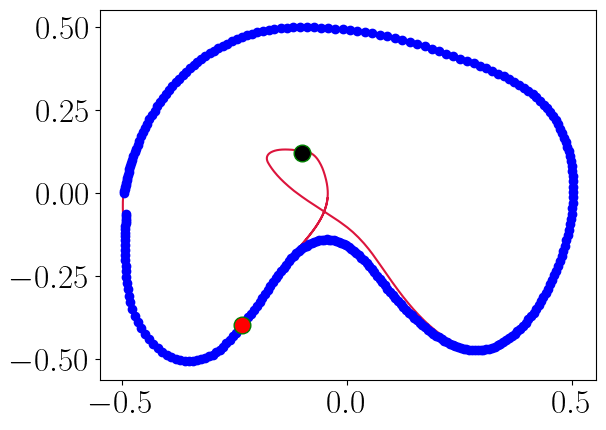

In [34]:
font = {'size': 24}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

figure, axes = plt.subplots()
plt.plot(xall[:, 0], xall[:, 1], c="crimson", label="Inference")
model_y = model_load(ts_new, ys[0, 0])
plt.plot(xref[:, 0], xref[:, 1], 'o', c="blue", label="Model")
plt.plot(dirt[0], dirt[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='black')
plt.plot(switch_pos_ref[0], switch_pos_ref[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='red')
# plt.legend()
# plt.tight_layout()
plt.show()

## CBF, CLF implementation at inference: STL **without mixing**

In [59]:
# @title
ys = traj_all_process
indx = 0
x = ys[indx,0,:]
xall = jnp.expand_dims(ys[indx,0,:], axis=0)
f = lambda z : model_load.func(_, z, _)
ts = ts_new
xref = model_load(ts, ys[indx, 0, :])

close_to_goal = np.linalg.norm(x - xref[-1])

i=0

N = 1 # horizon

dirt_sense = 0
wiped_dirt = 0
vopt_bound = 1000
epsilon_B = 0.01 # STL -> CBF
epsilon_margin = 0.005
sampling_ts = jnp.mean(jnp.diff(ts_new))
dti = 0.4*sampling_ts
t_star = 50*dti

near_target = 1
t_star_CBF = 50*dti

epsilon_margin_target = 0.01
epsilon_B_target = epsilon_B + epsilon_margin_target

switch_pos_ref = xref[switch_ind]

end_time = 1100*dti # 1300
current_time = 0

B_all = []
vopt_all = []
cmd_vel = []
dB_dt_all = []
alpha_BB_all = []
dB_dt_alpha_B_all = []
dB_dx_all = []
gamma_t_all = []

dirt_t = 0
nominal_t = 0

STL = []
CBF = []
xref_all=[]
constraint_all = []
rad_B = []
alpha_all=[]

cmd_vel_prevs=0.0*f(x)
vopt_prevs=0.0*f(x)

vopt_analytical_all = []

alpha_B = 5
alpha_V = 20

beta_t = 0
dt_beta_t = 0.05
beta_t_all=[]

trans_period1 = 0
trans_period2 = 0

to_dirt = 0
back_to_target = 0

while(current_time < end_time):

  i += 1

  current_time += dti

  x1=np.asarray(x)

  tsi = jnp.array([0, dti])

  closest_ind = np.argmin(np.linalg.norm(xref - x1, axis=1))

  go_to_ind = closest_ind + N
  if go_to_ind + N >= xref.shape[0]:
    go_to_ind = 0

  xref_t = xref[go_to_ind]

  fx1 = np.asarray(f(x1))
  fxref_t = np.asarray(f(xref_t))

  Q = np.eye(x1.shape[0])
  vopt = cp.Variable(x1.shape[0])

  # sensing
  if dirt_sense == 0:
    dirt_sense = np.linalg.norm(switch_pos_ref - x1) < 0.1

  # Different modes
  if dirt_sense == 1:
    if dirt_t == 0:
      wiped_dirt = 0
      print('Start wiping dirt!')
      trans_period1 = 1
      init_ball = (np.linalg.norm(dirt - x1) + 0.05)**2
      k = init_ball - epsilon_B**2

    if wiped_dirt == 0:
      wiped_dirt = np.linalg.norm(dirt - x1)<(epsilon_B + epsilon_margin)

    if wiped_dirt==0 or trans_period1 or trans_period2:
      if trans_period2:
        gamma_t = epsilon_margin**2 + 2*epsilon_B*epsilon_margin
        dB_dt = 0.
      if trans_period1:
        beta_t = np.clip(beta_t + dt_beta_t, 0., 1.)
        if beta_t == 1.:
          trans_period1 = 0
      vopt1 = cp.Variable(x1.shape[0])
      gamma_t = (k) * (np.exp(-(dirt_t/t_star)))
      B = epsilon_B**2 - (x1 - dirt).T @ (x1 - dirt) + gamma_t
      dB_dx = -2*(x1 - dirt).T
      dB_dt = (k) * (np.exp(-(dirt_t/t_star)))*(-1/t_star)
      alpha_BB = alpha_B*B**1
      constraints = [dB_dx@(fx1 + vopt1) + dB_dt >= -alpha_BB, fx1 + vopt1<=vopt_bound, fx1 + vopt1>=-vopt_bound]
      prob1 = cp.Problem(cp.Minimize(cp.quad_form(vopt1, Q)),
                        constraints)
      prob1.solve()
      if wiped_dirt == 0:
        B_all.append(B)
        rad_B.append(np.sqrt(epsilon_B**2 + gamma_t))
        dB_dt_all.append(dB_dt)
        dB_dx_all.append(dB_dx)
        dB_dt_alpha_B_all.append(-alpha_BB-dB_dt)
        alpha_BB_all.append(-alpha_BB)
        gamma_t_all.append(gamma_t)
        alpha_all.append(alpha_B)

      if dB_dx @ (fx1) + dB_dt >= -alpha_BB:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx @ (fx1) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      dirt_t += dti

  if wiped_dirt == 1:
    if nominal_t == 0:
      print('Wiped dirt! going back to target!')
      trans_period2 = 1
      dirt_sense = 0
      dirt_t = 0.
      init_ball_CBF = (np.linalg.norm(xref_t - x1) + 0.05)**2
      k_CBF = init_ball_CBF - epsilon_B**2

    if trans_period2:
      beta_t = np.clip(beta_t - dt_beta_t, 0., 1.)
      if beta_t == 0.:
        trans_period2 = 0

    near_target = np.linalg.norm(xref_t - x1)<(epsilon_B)

    if near_target == 0:
      gamma_t_CBF = 0
      B_CBF = (x1 - xref_t).T @ (x1 - xref_t) + gamma_t_CBF
      dB_dx_CBF = 2*(x1 - xref_t).T
      dB_dt_CBF = 0
      alpha_BB_CBF = alpha_V*B_CBF
      constraints = [dB_dx_CBF@(fx1 + vopt - fxref_t) + dB_dt_CBF <= -alpha_BB_CBF,
                      fx1 + vopt<=vopt_bound, fx1 + vopt>=-vopt_bound]
      prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)),
                        constraints)
      prob.solve()
      B_all.append(B_CBF)
      rad_B.append(np.sqrt(gamma_t_CBF))
      dB_dt_all.append(dB_dt_CBF)
      dB_dx_all.append(dB_dx_CBF)
      dB_dt_alpha_B_all.append(-alpha_BB_CBF-dB_dt_CBF)
      alpha_BB_all.append(-alpha_BB_CBF)
      gamma_t_all.append(gamma_t_CBF)
      alpha_all.append(alpha_B)
      if dB_dx_CBF @ (fx1 - fxref_t) + dB_dt_CBF <= -alpha_BB_CBF:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx_CBF @ (fx1 - fxref_t) - dB_dt_CBF - alpha_BB_CBF) * dB_dx_CBF.T/(dB_dx_CBF @ dB_dx_CBF.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))
      nominal_t += dti

  if near_target:
    if wiped_dirt == 1:
      wiped_dirt = 0
      nominal_t = 0.
    vopt = cp.Variable(x1.shape[0])
    B = (x1 - xref_t).T @ (x1 - xref_t)
    dB_dx = 2*(x1 - xref_t).T
    alpha_BB = alpha_V*B
    constraints = [dB_dx@(fx1 - fxref_t + vopt) <= -alpha_BB, fx1 + vopt<=vopt_bound,
                    fx1 + vopt>=-vopt_bound]

    prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)),
                      constraints)
    prob.solve()

    if beta_t == 0.0:
      B_all.append(B)
      rad_B.append(np.sqrt(0))
      dB_dt = 0.0
      dB_dt_all.append(dB_dt)
      dB_dx_all.append(dB_dx)
      dB_dt_alpha_B_all.append(-alpha_BB)
      alpha_BB_all.append(-alpha_BB)
      gamma_t_all.append(0)
      alpha_all.append(alpha_B)
      if dB_dx @ (fx1 - fxref_t) + dB_dt <= -alpha_BB:
        vopt_analytical = 0.0*fx1
      else:
        vopt_analytical= (-dB_dx @ (fx1 - fxref_t) - dB_dt - alpha_BB) * dB_dx.T/(dB_dx @ dB_dx.T)
      vopt_analytical_all.append(jnp.linalg.norm(vopt_analytical))

  if trans_period1:
    to_dirt = 1
    u1 = vopt.value # target
    u2 = vopt1.value # STL
    # u_final = (1-beta_t)*u1 + beta_t*u2
    u_final = u2

  elif trans_period2:
    to_dirt = 0
    back_to_target = 1
    u1 = vopt.value # target CBF
    u2 = vopt1.value # STL
    # u_final = (1-beta_t)*u1 + beta_t*u2
    u_final = u1

  else:
    if dirt_sense == 1 and wiped_dirt == 0:
      to_dirt = 1
      u_final = vopt1.value # STL
    elif wiped_dirt ==1 and near_target == 0:
      back_to_target = 1
      u_final = vopt.value # target CBF
    elif near_target == 1:
      back_to_target = 0
      u_final = vopt.value # target

  f1_final = f(x) + u_final

  xnext = f1_final*dti + x

  cmd_vel_prevs = f1_final
  cmd_vel.append(jnp.linalg.norm(cmd_vel_prevs))
  vopt_prevs = u_final
  vopt_all.append(jnp.linalg.norm(u_final))

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  STL.append(to_dirt)
  CBF.append(back_to_target)
  xref_all.append(xref_t)
  beta_t_all.append(beta_t)

  x = xnext

  close_to_goal = np.linalg.norm(x - xref[-1])

  if(i%100==0):
    print(f"Time: {i}, Position: {x}")

Time: 100, Position: [-0.28978634 -0.48181418]
Start wiping dirt!
Time: 200, Position: [-0.053482   -0.03841618]
Wiped dirt! going back to target!
Time: 300, Position: [-0.04545933 -0.02528144]
Time: 400, Position: [ 0.15523002 -0.3313038 ]
Time: 500, Position: [ 0.40070894 -0.37493595]
Time: 600, Position: [0.46638092 0.21189293]
Time: 700, Position: [-0.0815401  0.5009049]
Time: 800, Position: [-0.46097988  0.16372068]
Time: 900, Position: [-0.49358454 -0.21765085]
Start wiping dirt!
Time: 1000, Position: [-0.19229983 -0.30921292]
Time: 1100, Position: [-0.06049353  0.07012299]


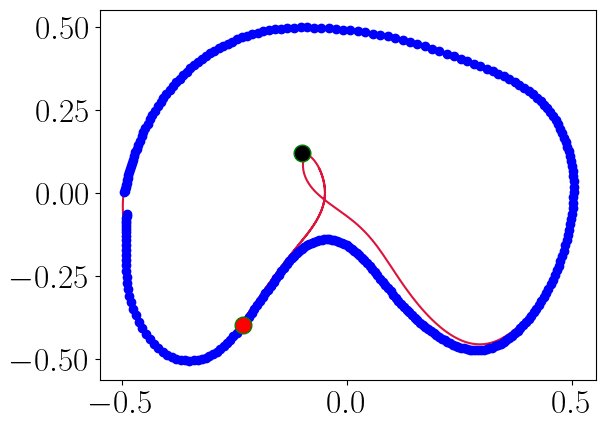

In [60]:
font = {'size': 24}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

figure, axes = plt.subplots()
plt.plot(xall[:, 0], xall[:, 1], c="crimson", label="Inference")
model_y = model_load(ts_new, ys[0, 0])
plt.plot(xref[:, 0], xref[:, 1], 'o', c="blue", label="Model")
plt.plot(dirt[0], dirt[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='black')
plt.plot(switch_pos_ref[0], switch_pos_ref[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='red')
# plt.legend()
# plt.tight_layout()
plt.show()

## Animation

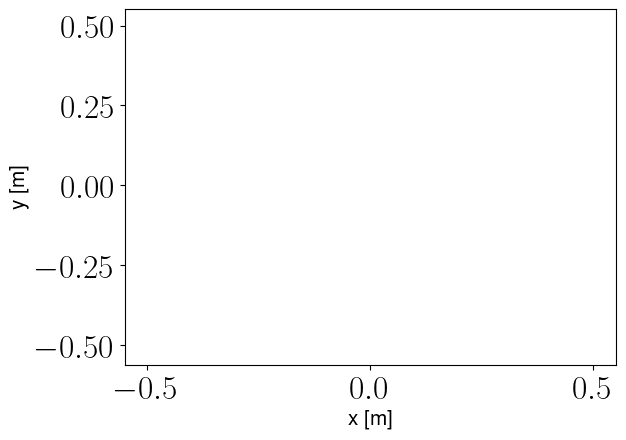

In [61]:
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
%matplotlib inline

# Set up the graph using Matplotlib
fig, ax = plt.subplots()
fig.tight_layout()
ax.set_ylabel('y [m]', fontsize=15)
ax.set_xlabel('x [m]', fontsize=15)
# ax.get_xaxis().set_label_coords(0.5, 0.12)

# Initiate camera
camera = Camera(fig)

# first_STL=STL.index(1)
# from_STL = STL[first_STL:]
# STL_to_Lyap = from_STL.index(0)
# STL_to_Lyap = 1000

# start_ind = 500
# end_ind = 520
start_ind = 1
end_ind = int(xall.shape[0])
# start_ind = 1000
# end_ind = 1020

# start_ind = first_STL - 10
# end_ind = first_STL + STL_to_Lyap + 500



# Create individual frames
for j in range(start_ind+1, end_ind, 10):


    ax.plot(model_y[:, 0], model_y[:, 1], c="green", label='Target trajectory')

    # Projectile's trajectory
    x = xall[start_ind:j, 0]
    y = xall[start_ind:j, 1]

    # Show Projectile's location
    ax.plot(x[-1], y[-1], marker='o', markersize=12, markeredgecolor='r', markerfacecolor='r', label='Robot')

    # Show Projectile's trajectory
    ax.plot(x, y, color='r', lw=2, linestyle='--')

    # Dirt
    ax.plot(dirt[0], dirt[1], marker='o', markersize=14, markeredgecolor='black', markerfacecolor='black', label='Dirt')

    ## CBF radius
    if STL[j-1] == 1:
      center = dirt
    elif CBF[j-1] == 1:
      center = xref_all[j-1]
      ax.plot(center[0], center[1], marker='o', markersize=12, markeredgecolor='black', markerfacecolor='orange', label='Target point')
    else:
      center = xref_all[j-1]
    # center = xref_all[j-1]

    circle = plt.Circle((center), rad_B[j-1],fill = True, facecolor='orange', alpha=0.5)
    ax.add_artist(circle)

    # STL start
    # ax.plot(switch_pos_ref[0], switch_pos_ref[1], marker='o', markersize=12, markeredgecolor='g', markerfacecolor='red')

    s = "t: " + str(j-1)
    STL_flag = "STL: " + str(STL[j-1])
    CBF_radius = "CBF radius: " + str(round(rad_B[j-1], 3))

    # ax.text(0.6, 0.8, s, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.7, STL_flag, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 18)
    ax.text(0.5, 0.6, CBF_radius, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 18)
    # ax.legend()
    # Capture frame
    camera.snap()

# Create animation
anim = camera.animate(interval = 600, repeat = True, repeat_delay = 5000)

# Inline display
HTML(anim.to_html5_video())

## Plots for analysis

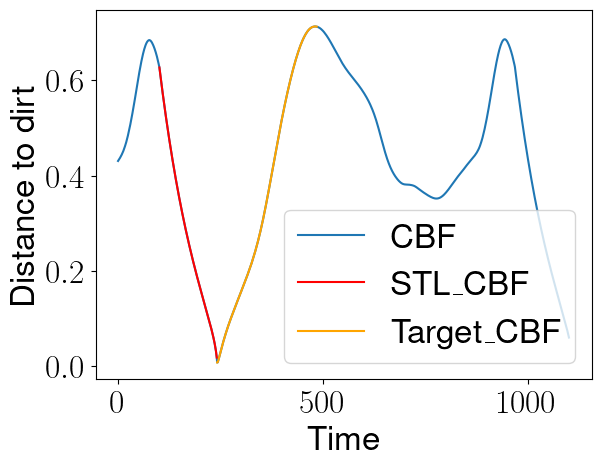

In [73]:
first_STL=STL.index(1)
from_STL = STL[first_STL:]
STL_to_CBF = from_STL.index(0)

first_CBF=CBF.index(1)
from_CBF = CBF[first_CBF:]
CBF_to_Lyap = from_CBF.index(0)

plt.plot(jnp.linalg.norm(xall - dirt ,axis=1), label='CBF')
plt.plot(np.arange(first_STL,first_STL + STL_to_CBF), jnp.linalg.norm(xall - dirt ,axis=1)[first_STL:first_STL + STL_to_CBF], color='red', label='STL_CBF')
plt.plot(np.arange(first_CBF,first_CBF + CBF_to_Lyap), jnp.linalg.norm(xall - dirt ,axis=1)[first_CBF:first_CBF + CBF_to_Lyap], color='orange', label='Target_CBF')
plt.ylabel('Distance to dirt')
plt.xlabel('Time')
plt.legend()

Text(0.5, 0, 'Time')

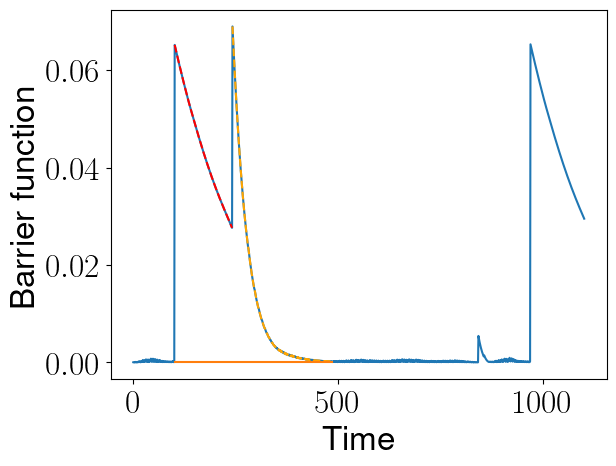

In [74]:
plt.plot(B_all, label='Lyapunov')
time_STL = np.arange(first_STL,first_STL + STL_to_CBF)
time_CBF = np.arange(first_CBF,first_CBF + CBF_to_Lyap)
time_all = np.concatenate((time_STL, time_CBF))
plt.plot(time_STL, B_all[first_STL:first_STL + STL_to_CBF], '--', color='red', label='STL_CBF')
plt.plot(time_CBF, B_all[first_CBF:first_CBF + CBF_to_Lyap], '--', color='orange', label='Target_CBF')
plt.plot(time_all, np.repeat(0, int(time_STL.shape[0] + time_CBF.shape[0])))
plt.ylabel('Barrier function')
plt.xlabel('Time')
# plt.legend()

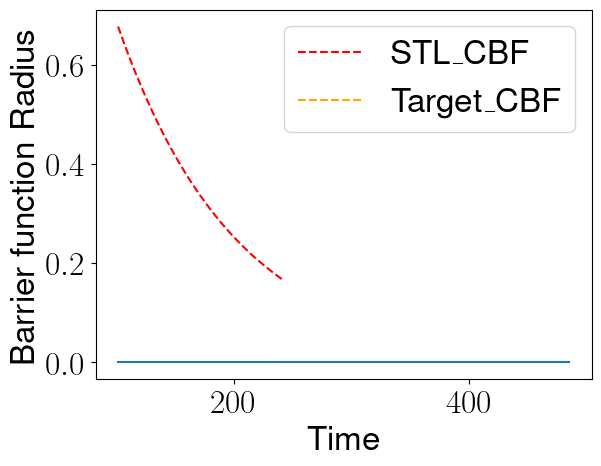

In [75]:
# plt.plot(B_all, label='Lyapunov')
plt.plot(time_STL, rad_B[first_STL:first_STL + STL_to_CBF], '--', color='red', label='STL_CBF')
plt.plot(time_CBF, rad_B[first_CBF:first_CBF + CBF_to_Lyap], '--', color='orange', label='Target_CBF')
plt.plot(time_all, np.repeat(epsilon_B**2, time_all.shape[0]))
# plt.plot(np.arange(first_STL+110,first_STL + STL_to_Lyap), B_all[first_STL+110:first_STL + STL_to_Lyap], color='red', label='STL_CBF')
plt.ylabel('Barrier function Radius')
plt.xlabel('Time')
plt.legend()

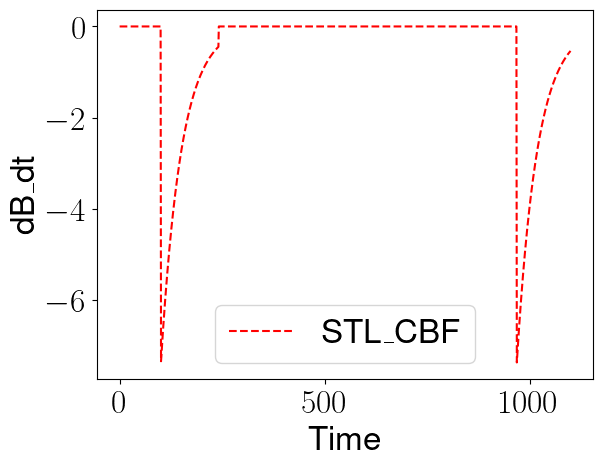

In [76]:

# plt.plot(B_all, label='Lyapunov')

plt.plot(dB_dt_all, '--', color='red', label='STL_CBF')


# plt.plot(time_STL, dB_dt_all[first_STL:first_STL + STL_to_CBF], '--', color='red', label='STL_CBF')
# plt.plot(time_CBF, dB_dt_all[first_CBF:first_CBF + CBF_to_Lyap], '--', color='orange', label='Target_CBF')
# plt.plot(time_all, np.repeat(0, time_all.shape[0]))
# # plt.plot(np.arange(first_STL+110,first_STL + STL_to_Lyap), B_all[first_STL+110:first_STL + STL_to_Lyap], color='red', label='STL_CBF')
plt.ylabel('dB_dt')
plt.xlabel('Time')
plt.legend()

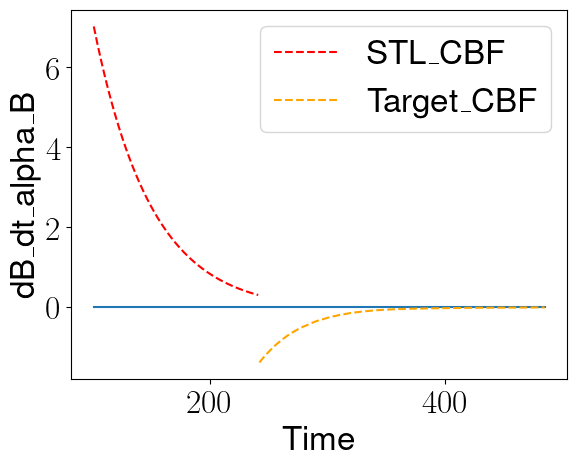

In [77]:
# plt.plot(B_all, label='Lyapunov')
plt.plot(time_all, np.repeat(0, time_all.shape[0]))
plt.plot(time_STL, dB_dt_alpha_B_all[first_STL:first_STL + STL_to_CBF], '--', color='red', label='STL_CBF')
plt.plot(time_CBF, dB_dt_alpha_B_all[first_CBF:first_CBF + CBF_to_Lyap], '--', color='orange', label='Target_CBF')

# plt.plot(np.arange(first_STL+110,first_STL + STL_to_Lyap), B_all[first_STL+110:first_STL + STL_to_Lyap], color='red', label='STL_CBF')
plt.ylabel('dB_dt_alpha_B')
plt.xlabel('Time')
plt.legend()

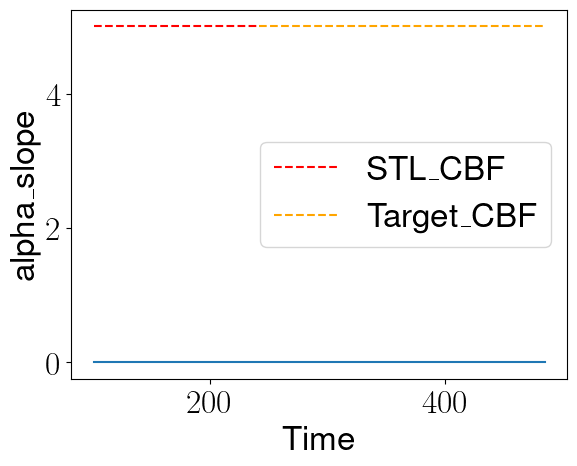

In [78]:
plt.plot(time_all, np.repeat(0, int(time_STL.shape[0] + time_CBF.shape[0])))
plt.plot(time_STL, alpha_all[first_STL:first_STL + STL_to_CBF], '--', color='red', label='STL_CBF')
plt.plot(time_CBF, alpha_all[first_CBF:first_CBF + CBF_to_Lyap], '--', color='orange', label='Target_CBF')
# plt.plot(time_all, gamma_t_all[first_STL:first_STL + STL_to_Lyap+1], '-o', color='red')
# plt.plot(np.arange(first_STL+110,first_STL + STL_to_Lyap), B_all[first_STL+110:first_STL + STL_to_Lyap], color='red', label='STL_CBF')
plt.ylabel('alpha_slope')
plt.xlabel('Time')
plt.legend()

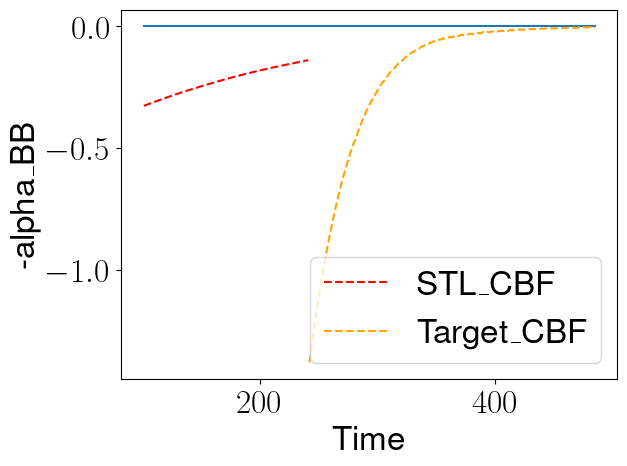

In [79]:
plt.plot(time_all, np.repeat(0, int(time_STL.shape[0] + time_CBF.shape[0])))
plt.plot(time_STL, alpha_BB_all[first_STL:first_STL + STL_to_CBF], '--', color='red', label='STL_CBF')
plt.plot(time_CBF, alpha_BB_all[first_CBF:first_CBF + CBF_to_Lyap], '--', color='orange', label='Target_CBF')
# plt.plot(time_all, gamma_t_all[first_STL:first_STL + STL_to_Lyap+1], '-o', color='red')
# plt.plot(np.arange(first_STL+110,first_STL + STL_to_Lyap), B_all[first_STL+110:first_STL + STL_to_Lyap], color='red', label='STL_CBF')
plt.ylabel('-alpha_BB')
plt.xlabel('Time')
plt.legend()

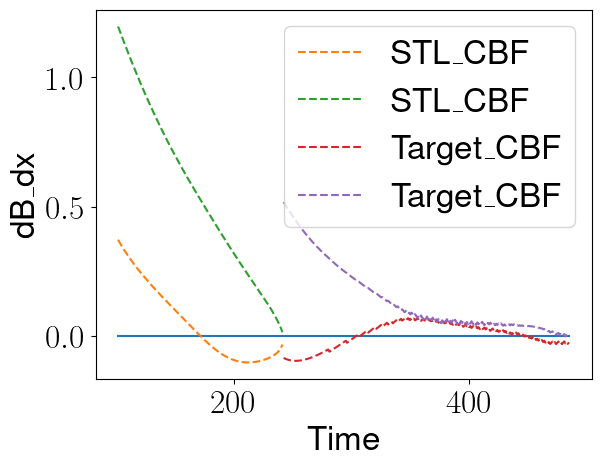

In [80]:
dB_dx_STL = np.asarray(dB_dx_all[first_STL:first_STL + STL_to_CBF])
dB_dx_CBF = np.asarray(dB_dx_all[first_CBF:first_CBF + CBF_to_Lyap])
plt.plot(time_all, np.repeat(0, time_all.shape[0]))
plt.plot(time_STL, dB_dx_STL, '--', label='STL_CBF')
plt.plot(time_CBF, dB_dx_CBF, '--', label='Target_CBF')
# plt.plot(np.arange(first_STL+110,first_STL + STL_to_Lyap), B_all[first_STL+110:first_STL + STL_to_Lyap], color='red', label='STL_CBF')
plt.ylabel('dB_dx')
plt.xlabel('Time')
plt.legend()

Text(0.5, 0, 'Time steps')

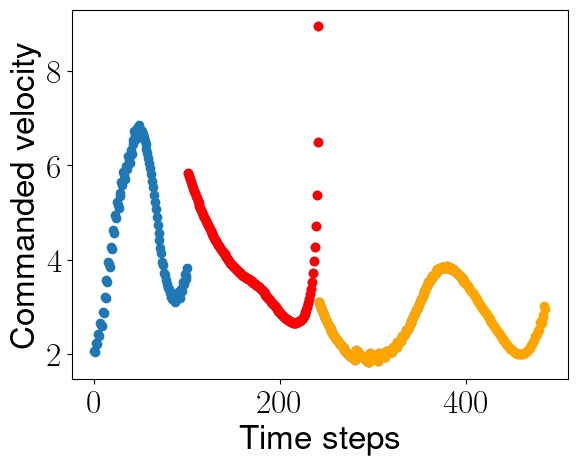

In [81]:
plt.plot(cmd_vel[:400], 'o', label='CBF')
plt.plot(np.arange(first_STL,first_STL + STL_to_CBF), cmd_vel[first_STL:first_STL + STL_to_CBF], 'o', color='red', label='STL_CBF')
plt.plot(np.arange(first_CBF,first_CBF + CBF_to_Lyap), cmd_vel[first_CBF:first_CBF + CBF_to_Lyap], 'o', color='orange', label='Target_CBF')
# plt.plot(np.arange(first_STL,first_STL + STL_to_Lyap), constraint_all[first_STL:first_STL + STL_to_Lyap], color='red', label='STL_CBF')
# plt.plot(first_STL + STL_to_Lyap, constraint_all[first_STL + STL_to_Lyap], marker='o')
plt.ylabel('Commanded velocity')
plt.xlabel('Time steps')
# plt.legend()

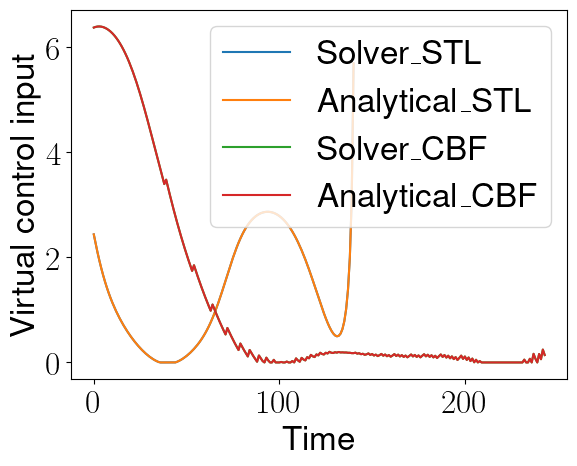

In [82]:
plt.plot(vopt_all[first_STL:first_STL + STL_to_CBF], label='Solver_STL')
plt.plot(vopt_analytical_all[first_STL:first_STL + STL_to_CBF], label='Analytical_STL')
plt.plot(vopt_all[first_CBF:first_CBF + CBF_to_Lyap], label='Solver_CBF')
plt.plot(vopt_analytical_all[first_CBF:first_CBF + CBF_to_Lyap], label='Analytical_CBF')
plt.ylabel('Virtual control input')
plt.xlabel('Time')
plt.legend()

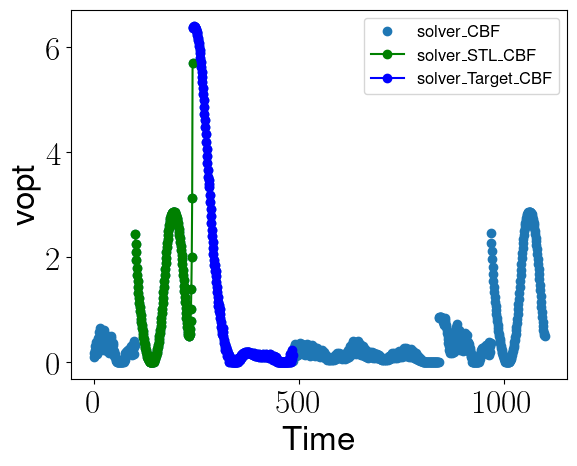

In [83]:
# plt.plot(vopt_analytical_all, 'o', label='analytical_CBF')
# plt.plot(np.arange(first_STL,first_STL + STL_to_CBF), vopt_analytical_all[first_STL:first_STL + STL_to_CBF], 'o', color='red', label='STL_CBF')
# plt.plot(np.arange(first_CBF,first_CBF + CBF_to_Lyap), vopt_analytical_all[first_CBF:first_CBF + CBF_to_Lyap], 'o', color='orange', label='Target_CBF')

plt.plot(vopt_all, 'o', label='solver_CBF')
plt.plot(np.arange(first_STL,first_STL + STL_to_CBF), vopt_all[first_STL:first_STL + STL_to_CBF], '-o', color='green', label='solver_STL_CBF')
plt.plot(np.arange(first_CBF,first_CBF + CBF_to_Lyap), vopt_all[first_CBF:first_CBF + CBF_to_Lyap], '-o', color='blue', label='solver_Target_CBF')

plt.ylabel('vopt')
plt.xlabel('Time')
plt.legend(fontsize='12')

Model parameters:

Line:

lr_strategy=(3e-3,),
steps_strategy=(5000,),
length_strategy=(1,),
width_size=32,
depth=3,

Saeghe:

lr_strategy=(3e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

BendedLine(okayish), Zshape, Worm:

lr_strategy=(4e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,

Trapezoid, Sine, Wshape(bad):

lr_strategy=(3e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

Angle:

lr_strategy=(4e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

Leaf_1:

lr_strategy=(3e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=5,

L/J2/J/GShape:

lr_strategy=(6e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,

RShape, PShape:

lr_strategy=(6e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=64,
depth=3,

Sshape, Snake, Sharpc:

lr_strategy=(4e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,

Multi_Models_1, 3, 4:

lr_strategy=(6e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

Leaf_2: width_size = 128

Khmahesh(bad), Hee:

lr_strategy=(2e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=128,
depth=3,

Multi_Models_2, DoubleBendedLine, CShape, Spoon, NShape:

lr_strategy=(9e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,